In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')
%cd gdrive/Shareddrives/Thesis (PS4)/[01] Colab/[03] MV

Mounted at /content/gdrive
/content/gdrive/Shareddrives/Thesis (PS4)/[01] Colab/[03] MV


#Importing libraries

In [ ]:
import numpy as np
import pandas as pd

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

In [ ]:
from sklearn import metrics
from sklearn.ensemble import RandomForestRegressor
from sklearn.feature_selection import VarianceThreshold
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, mean_squared_log_error, median_absolute_error, explained_variance_score, max_error
from sklearn.model_selection import ShuffleSplit


In [ ]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint

In [ ]:
import joblib

In [ ]:
from sklearn import preprocessing
from scipy import stats
from copy import deepcopy


In [ ]:
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import summary_table

In [ ]:
import glob # to read multiple files
import os
from sklearn.model_selection import cross_val_predict
from collections import defaultdict
import json
import statsmodels.api as sm
import matplotlib.pyplot as plt


#Model development and revalidation

## Defining Functions


###Y-Scrambling

In [ ]:
def Y_scrambling(X_internal, X_external, Y_internal, Y_external, df_name):
    predictionOnExternal_scrambledtrain = []
    predictionOnInternal_scrambledtrain = []

    for randomseedcounter in range(1, 11):  # 10 iterations
        y_train_scrambled = deepcopy(Y_internal.values)
        X_train_scrambled = deepcopy(X_internal.values)

        np.random.shuffle(y_train_scrambled)
        np.random.shuffle(X_train_scrambled)

        RF_scrambled = RandomForestRegressor(max_depth=60,
                                             max_features='sqrt',
                                             min_samples_split=4,
                                             n_estimators=940,
                                             random_state=42,
                                             n_jobs=-1,
                                             verbose=1)  ## TO EDIT BASED FROM BEST HP

        RF_scrambled.fit(X_internal, y_train_scrambled)

        # Prediction on the external set
        y_predict_scrambled = RF_scrambled.predict(X_external)
        r2_test_scrambled = (RF_scrambled.score(X_external, Y_external))**2
        predictionOnExternal_scrambledtrain.append(r2_test_scrambled)

        # Prediction on the internal set
        y_predict_scrambled_predictTrain = RF_scrambled.predict(X_internal)
        r2_train_scrambled = (RF_scrambled.score(X_internal, Y_internal))**2
        predictionOnInternal_scrambledtrain.append(r2_train_scrambled)

    result = pd.DataFrame({
        'R2_scrambled': predictionOnInternal_scrambledtrain,
        'Q2_scrambled': predictionOnExternal_scrambledtrain
    })

    result.to_csv(f'Y_scrambling_results_{df_name}.csv', index=False)

    return predictionOnExternal_scrambledtrain, predictionOnInternal_scrambledtrain

###Plots

In [ ]:
def plot_model(df_name, X_internal, X_external, Y_internal, Y_external, rf, hx):
    # Prepare plot
    fig_size = plt.rcParams["figure.figsize"]
    fig_size[0] = 15
    fig_size[1] = 5

    # Train Set
    plt.subplot(1, 3, 1)
    m = rf.fit(X_internal, Y_internal)
    x_train = np.array(Y_internal)
    y_train = m.predict(X_internal).flatten()
    sns.regplot(x=x_train, y=y_train, scatter_kws={'color': '#27187eff', 'alpha': 0.3}, line_kws={'color': 'gray'}, ci=None)
    plt.xlabel("Experimental $pIC_{50}$ values", fontsize=10)
    plt.ylabel("Predicted $pIC_{50}$ values", fontsize=10)
    plt.title("Train Set")

    # CV Set
    plt.subplot(1, 3, 2)
    cv = cross_val_predict(rf, X_internal, Y_internal, cv=10, n_jobs=-1)
    x_test = np.array(Y_internal)
    y_test = cv
    sns.regplot(x=x_test, y=y_test, scatter_kws={'color': '#FF7200', 'alpha': 0.3}, line_kws={'color': 'gray'}, ci=None)
    plt.xlabel("Experimental $pIC_{50}$ values", fontsize=10)
    plt.ylabel("Predicted $pIC_{50}$ values", fontsize=10)
    plt.title("CV Set")

    # External Set
    plt.subplot(1, 3, 3)
    x_test = np.array(Y_external)
    y_test = m.predict(X_external).flatten()
    sns.regplot(x=x_test, y=y_test, scatter_kws={'color': '#2b9348', 'alpha': 0.3}, line_kws={'color': 'gray'}, ci=None)
    plt.xlabel("Experimental $pIC_{50}$ values", fontsize=10)
    plt.ylabel("Predicted $pIC_{50}$ values", fontsize=10)
    plt.title("External Set")

    plt.tight_layout()
    plt.savefig(f'{df_name}_compare.png', dpi=300)

###Model

In [ ]:
def build_model(X, Y, config=None):
    if config is None:
        config = {
            'hx': X.columns.tolist(),
            'random_state': 45,  #edit random state
            'df_name': 'KlekotaRothCount', #edit df name
            'rf_params': { #edit params
                'max_depth': 60,
                'max_features': 'sqrt',
                'min_samples_split': 4,
                'n_estimators': 940,
                'random_state': 42,
                'n_jobs': -1,
                'verbose': 1
            }
        }

    models = []
    all_metrics_results = {
        'MAE_train': [],
        'R2_train': [],
        'RMSE_train': [],
        'MAE_CV': [],
        'Q2_CV': [],
        'RMSE_CV': [],
        'MAE_External': [],
        'Q2_External': [],
        'RMSE_External': []
    }

    # Extracting parameters from the config dictionary
    hx = config['hx']
    random_state = config['random_state']
    df_name = config['df_name']
    rf_params = config['rf_params']

    feature_importances_results = {
        'importances_dict': defaultdict(list)
    }

    y_scrambling_results_external = []
    y_scrambling_results_internal = []

    # Train-test split
    X_internal, X_external, Y_internal, Y_external = train_test_split(X, Y, test_size=0.2, random_state=random_state) #edit random state

    # Internal set
    rf = RandomForestRegressor(**rf_params)
    rf.fit(X_internal, Y_internal)
    prediction_internal = rf.predict(X_internal)

    # Cross-validation
    cv = cross_val_predict(rf, X_internal, Y_internal, cv=10, n_jobs=-1)

    # External set
    prediction_external = rf.predict(X_external)

    # Save the trained model using joblib
    model_filename = f'trained_model_{df_name}.joblib'
    joblib.dump(rf, model_filename)

    # Append the model to the list
    models.append(model_filename)

    # Store results for the single split
    all_metrics_results['MAE_train'].append(mean_absolute_error(Y_internal, prediction_internal))
    all_metrics_results['R2_train'].append(r2_score(Y_internal, prediction_internal))
    all_metrics_results['RMSE_train'].append(np.sqrt(mean_squared_error(Y_internal, prediction_internal)))
    all_metrics_results['MAE_CV'].append(mean_absolute_error(Y_internal, cv))
    all_metrics_results['Q2_CV'].append(r2_score(Y_internal, cv))
    all_metrics_results['RMSE_CV'].append(np.sqrt(mean_squared_error(Y_internal, cv)))
    all_metrics_results['MAE_External'].append(mean_absolute_error(Y_external, prediction_external))
    all_metrics_results['Q2_External'].append(r2_score(Y_external, prediction_external))
    all_metrics_results['RMSE_External'].append(np.sqrt(mean_squared_error(Y_external, prediction_external)))

    # Feature Importance
    feature_importance = rf.feature_importances_
    importances = list(zip(hx, feature_importance))
    importances = sorted(importances, key=lambda x: x[1], reverse=True)

    # Feature importance Visualization
    fig_size = plt.rcParams["figure.figsize"]
    fig_size[0] = 5
    fig_size[1] = 10

    barlist = plt.barh(range(20), [x[1] for x in importances[:20]],
                      color="#27187eff", xerr=[x[1] for x in importances[:20]],
                      align="center", error_kw=dict(ecolor='gray', lw=2, capsize=5, capthick=2))

    plt.yticks(range(20), [x[0] for x in importances[:20]])
    plt.ylim([-1, 20])

    plt.xlabel(r"$\bf{Gini}$" + " " + r"$\bf{index}$", fontsize=12)
    ax = plt.gca()
    ax.invert_yaxis()
    plt.tight_layout(pad=2.0, w_pad=0.7, h_pad=2.0)

    # Save the feature importance plot
    plt.savefig(f'{df_name}_Feature_importances.png', dpi=300)
    plt.close()

    # Store feature importances
    for i, fx in enumerate(hx):
        feature_importances_results['importances_dict'][fx].append(feature_importance[i])

    # Y Scrambling
    y_scrambling_results_internal_split, y_scrambling_results_external_split = Y_scrambling(X_internal, X_external, Y_internal, Y_external, df_name)

    y_scrambling_results_external.append(y_scrambling_results_external_split)
    y_scrambling_results_internal.append(y_scrambling_results_internal_split)

    # Plotting
    plot_model(df_name, X_internal, X_external, Y_internal, Y_external, rf, hx)

    return (
        all_metrics_results,
        models,
        feature_importances_results,
        y_scrambling_results_external,
        y_scrambling_results_internal,
        rf)

##Dataset


In [ ]:
XYFeatureSelection = pd.read_csv ('pIC50_correlation_processed_KlekotaRothCount.csv')
Y = XYFeatureSelection['pIC50']
X = XYFeatureSelection.drop(columns=['pIC50'])

##Running all the defined functions

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 196 tasks      | elapsed:    1.5s
[Parallel(n_jobs=-1)]: Done 446 tasks      | elapsed:    3.5s
[Parallel(n_jobs=-1)]: Done 796 tasks      | elapsed:    6.2s
[Parallel(n_jobs=-1)]: Done 940 out of 940 | elapsed:    7.3s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done 196 tasks      | elapsed:    0.2s
[Parallel(n_jobs=2)]: Done 446 tasks      | elapsed:    0.4s
[Parallel(n_jobs=2)]: Done 796 tasks      | elapsed:    0.8s
[Parallel(n_jobs=2)]: Done 940 out of 940 | elapsed:    1.0s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done 196 tasks      | elapsed:    0.1s
[Par

Built model for a single DataFrame.


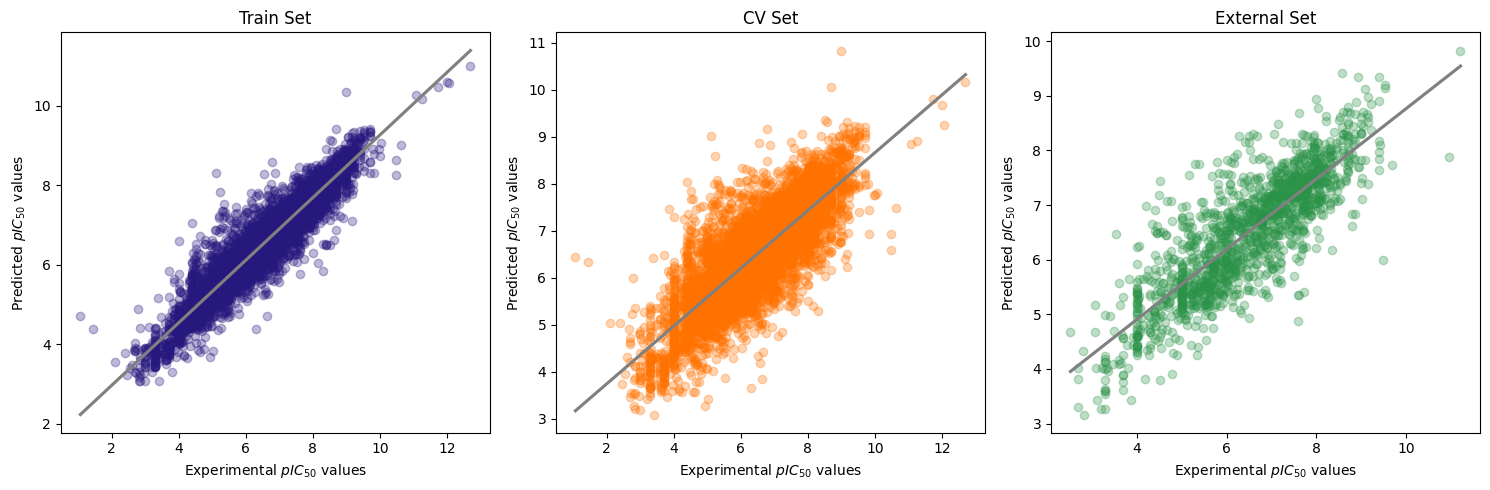

In [ ]:
all_metrics_results, models, feature_importances_results, y_scrambling_results_external, y_scrambling_results_internal, rf = build_model(
    X=X,
    Y=Y
)

# CSV for all metrics
pd.DataFrame(all_metrics_results).to_csv('/content/gdrive/Shareddrives/Thesis (PS4)/[01] Colab/[03] MV/KRC_model_results_metrics.csv', index=False)

# CSV for feature importances
pd.DataFrame(feature_importances_results['importances_dict']).to_csv('/content/gdrive/Shareddrives/Thesis (PS4)/[01] Colab/[03] MV/KRC_model_results_importances.csv', index=False)

print("Built model for a single DataFrame.")

#Applicability domain

##Dataset


In [ ]:
# Load data
XYFeatureSelection = pd.read_csv('pIC50_correlation_processed_KlekotaRothCount.csv')
Y = XYFeatureSelection['pIC50']
X = XYFeatureSelection.drop(columns=['pIC50'])


In [ ]:
# Train-test split
X_internal, X_external, Y_internal, Y_external = train_test_split(X, Y,
                                                                  test_size=0.2,
                                                                  random_state=45)

In [ ]:
# Fit and predict using filtered datasets
rf_params = {
    'max_depth': 60,
    'max_features': 'sqrt',
    'min_samples_split': 4,
    'n_estimators': 940,
    'random_state': 42,
    'n_jobs': -1,
    'verbose': 1
}


rf_internal = RandomForestRegressor(**rf_params)
rf_internal.fit(X_internal, Y_internal)

Y_internal_pred = rf_internal.predict(X_internal)
Y_external_pred = rf_internal.predict(X_external)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 196 tasks      | elapsed:    1.6s
[Parallel(n_jobs=-1)]: Done 446 tasks      | elapsed:    3.5s
[Parallel(n_jobs=-1)]: Done 796 tasks      | elapsed:    7.2s
[Parallel(n_jobs=-1)]: Done 940 out of 940 | elapsed:    9.1s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done 196 tasks      | elapsed:    0.2s
[Parallel(n_jobs=2)]: Done 446 tasks      | elapsed:    0.5s
[Parallel(n_jobs=2)]: Done 796 tasks      | elapsed:    0.8s
[Parallel(n_jobs=2)]: Done 940 out of 940 | elapsed:    0.9s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done 196 tasks      | elapsed:    0.1s
[Par

##Leverage and William's plot - INTERNAL EXTERNAL

In [ ]:
# Calculate Mean Squared Error for internal and external datasets
mse_internal = mean_squared_error(Y_internal, Y_internal_pred)
mse_external = mean_squared_error(Y_external, Y_external_pred)

In [ ]:
# Calculate Standardized Residuals
std_residuals_internal = (Y_internal - Y_internal_pred) / np.sqrt(mse_internal)
std_residuals_external = (Y_external - Y_external_pred) / np.sqrt(mse_external)

std_dev = 3

In [ ]:
Y_internal.shape

(5882,)

In [ ]:
# Calculate Leverage (H) values
hat_matrix_internal = np.dot(X_internal, np.dot(np.linalg.inv(np.dot(X_internal.T, X_internal)), X_internal.T))
hat_matrix_external = np.dot(X_external, np.dot(np.linalg.inv(np.dot(X_internal.T, X_internal)), X_external.T))

leverage_internal = np.diag(hat_matrix_internal)
leverage_external = np.diag(hat_matrix_external)

In [ ]:
# Leverage threshold calculation
k = X_internal.shape[1] - 1
n = X_internal.shape[0]
leverage_threshold = 3 * (k + 1) / n
leverage_threshold

0.04284257055423325

In [ ]:
# Identify outliers based on leverage and standardized residuals
outliers_leverage_internal = leverage_internal > leverage_threshold
outliers_std_residual_internal = np.abs(std_residuals_internal) > std_dev

outliers_leverage_external = leverage_external > leverage_threshold
outliers_std_residual_external = np.abs(std_residuals_external) > std_dev

# Combine the conditions to identify outliers
outliers_internal = outliers_leverage_internal | outliers_std_residual_internal
outliers_external = outliers_leverage_external | outliers_std_residual_external

# Compute the number and percentage of outliers
num_outliers_internal = np.sum(outliers_internal)
num_outliers_external = np.sum(outliers_external)

percentage_outliers_internal = (num_outliers_internal / len(std_residuals_internal)) * 100
percentage_outliers_external = (num_outliers_external / len(std_residuals_external)) * 100

# Print the number and percentage of outliers
print(f"Number of Internal Outliers: {num_outliers_internal}, Percentage: {percentage_outliers_internal:.2f}%")
print(f"Number of External Outliers: {num_outliers_external}, Percentage: {percentage_outliers_external:.2f}%")

Number of Internal Outliers: 162, Percentage: 2.75%
Number of External Outliers: 38, Percentage: 2.58%


In [ ]:
# Identify compounds for outliers
compounds_internal_outliers = np.where(outliers_internal)[0]
compounds_external_outliers = np.where(outliers_external)[0]

# Print compounds and num for internal and external outliers
print("\nCompounds for Internal Outliers:")
print(compounds_internal_outliers)
print("num of Internal Outliers:", num_outliers_internal)

print("\nCompounds for External Outliers:")
print(compounds_external_outliers)
print("num of External Outliers:", num_outliers_external)


percentage_outliers_internal = (num_outliers_internal / len(std_residuals_internal)) * 100
percentage_outliers_external = (num_outliers_external / len(std_residuals_external)) * 100

# Print the number and percentage of outliers
print(f"Percentage of Internal Outliers: {percentage_outliers_internal:.2f}%")
print(f"Percentage of External Outliers: {percentage_outliers_external:.2f}%")


Compounds for Internal Outliers:
[  49   84   85  103  117  122  229  263  363  402  403  448  479  480
  551  573  575  581  591  609  625  661  730  809  881  896  941  988
 1023 1025 1082 1110 1116 1139 1144 1179 1218 1223 1232 1233 1257 1275
 1322 1357 1368 1397 1408 1421 1426 1453 1462 1524 1554 1610 1658 1714
 1715 1768 1824 1942 2035 2084 2102 2111 2112 2169 2170 2234 2310 2314
 2376 2382 2442 2445 2465 2494 2566 2609 2673 2695 2709 2762 2766 2839
 2844 2910 2961 2988 3016 3120 3249 3268 3307 3332 3354 3436 3558 3583
 3635 3657 3664 3726 3781 3824 3957 3976 3992 4068 4082 4089 4171 4221
 4306 4311 4323 4330 4339 4356 4434 4484 4550 4574 4600 4657 4746 4752
 4769 4801 4807 4810 4856 4860 4870 4894 4908 4911 4918 4983 4991 4995
 5038 5063 5088 5117 5132 5209 5306 5376 5424 5478 5481 5511 5549 5580
 5598 5689 5718 5764 5790 5792 5816 5858]
num of Internal Outliers: 162

Compounds for External Outliers:
[   5   51   68  224  228  337  346  349  438  454  490  509  525  529
  545  6

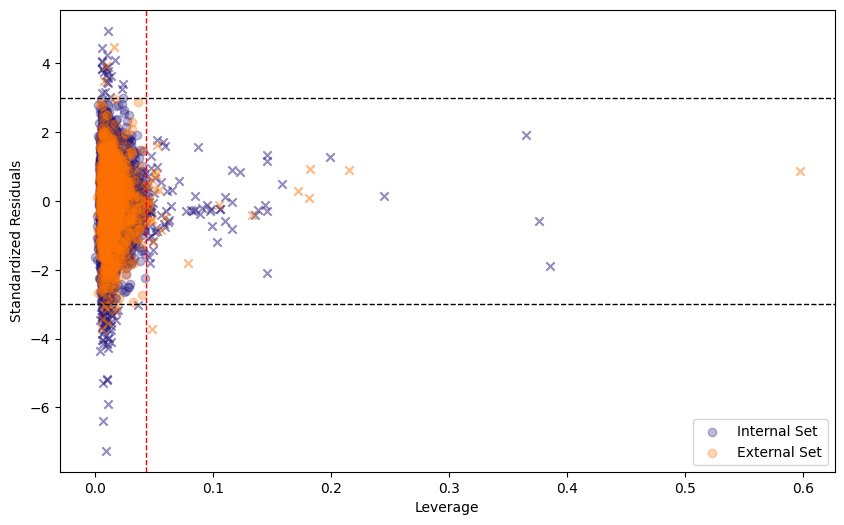

In [ ]:
# Plot
plt.figure(figsize=(10, 6))
plt.scatter(leverage_internal[~outliers_internal], std_residuals_internal[~outliers_internal], alpha=0.3, color='#27187eff', label='Internal Set')
plt.scatter(leverage_internal[outliers_internal], std_residuals_internal[outliers_internal], color='#27187eff', marker="x", alpha=0.5)
plt.scatter(leverage_external[~outliers_external], std_residuals_external[~outliers_external], alpha=0.3, color='#FF7200', label='External Set')
plt.scatter(leverage_external[outliers_external], std_residuals_external[outliers_external], color='#FF7200', marker="x", alpha=0.5)

plt.axvline(x=leverage_threshold, color='red', linestyle='--', linewidth=1)
plt.axhline(y=std_dev, color='black', linestyle='--', linewidth=1)
plt.axhline(y=-std_dev, color='black', linestyle='--', linewidth=1)

plt.xlabel('Leverage')
plt.ylabel('Standardized Residuals')
plt.legend(loc='lower right')

plt.savefig('KRC_williams_plot.png', dpi=300)
plt.show()


#AD MODEL 1


##removing outliers

In [ ]:
# Create a boolean mask for internal and external outliers
mask_internal_outliers = np.isin(np.arange(len(X_internal)), compounds_internal_outliers)
mask_external_outliers = np.isin(np.arange(len(X_external)), compounds_external_outliers)

# Remove internal outliers from training set
X_internal_filtered = X_internal[~mask_internal_outliers]
Y_internal_filtered = Y_internal[~mask_internal_outliers]

# Remove external outliers from test set
X_external_filtered = X_external[~mask_external_outliers]
Y_external_filtered = Y_external[~mask_external_outliers]

##AD Defining Functions


### AD Y-Scrambling

In [ ]:
def AD_Y_scrambling(X_internal, X_external, Y_internal, Y_external, df_name):
    predictionOnExternal_scrambledtrain = []
    predictionOnInternal_scrambledtrain = []

    for randomseedcounter in range(1, 11):  # 10 iterations
        y_train_scrambled = deepcopy(Y_internal.values)
        X_train_scrambled = deepcopy(X_internal.values)

        np.random.shuffle(y_train_scrambled)
        np.random.shuffle(X_train_scrambled)

        RF_scrambled = RandomForestRegressor(max_depth=60,
                                             max_features='sqrt',
                                             min_samples_split=4,
                                             n_estimators=940,
                                             random_state=42,
                                             n_jobs=-1,
                                             verbose=1)  ## TO EDIT BASED FROM BEST HP

        RF_scrambled.fit(X_internal, y_train_scrambled)

        # Prediction on the external set
        y_predict_scrambled = RF_scrambled.predict(X_external)
        r2_test_scrambled = (RF_scrambled.score(X_external, Y_external))**2
        predictionOnExternal_scrambledtrain.append(r2_test_scrambled)

        # Prediction on the internal set
        y_predict_scrambled_predictTrain = RF_scrambled.predict(X_internal)
        r2_train_scrambled = (RF_scrambled.score(X_internal, Y_internal))**2
        predictionOnInternal_scrambledtrain.append(r2_train_scrambled)

    result = pd.DataFrame({
        'R2_scrambled': predictionOnInternal_scrambledtrain,
        'Q2_scrambled': predictionOnExternal_scrambledtrain
    })

    result.to_csv(f'AD_Y_scrambling_results_{df_name}.csv', index=False)

    return predictionOnExternal_scrambledtrain, predictionOnInternal_scrambledtrain

###AD Plots

In [ ]:
def AD_plot_model(df_name, X_internal, X_external, Y_internal, Y_external, rf, hx):
    # Prepare plot
    fig_size = plt.rcParams["figure.figsize"]
    fig_size[0] = 15
    fig_size[1] = 5

    # Train Set
    plt.subplot(1, 3, 1)
    m = rf.fit(X_internal, Y_internal)
    x_train = np.array(Y_internal)
    y_train = m.predict(X_internal).flatten()
    sns.regplot(x=x_train, y=y_train, scatter_kws={'color': '#27187eff', 'alpha': 0.3}, line_kws={'color': 'gray'}, ci=None)
    plt.xlabel("Experimental $pIC_{50}$ values", fontsize=10)
    plt.ylabel("Predicted $pIC_{50}$ values", fontsize=10)
    plt.title("Train Set")

    # CV Set
    plt.subplot(1, 3, 2)
    cv = cross_val_predict(rf, X_internal, Y_internal, cv=10, n_jobs=-1)
    x_test = np.array(Y_internal)
    y_test = cv
    sns.regplot(x=x_test, y=y_test, scatter_kws={'color': '#FF7200', 'alpha': 0.3}, line_kws={'color': 'gray'}, ci=None)
    plt.xlabel("Experimental $pIC_{50}$ values", fontsize=10)
    plt.ylabel("Predicted $pIC_{50}$ values", fontsize=10)
    plt.title("CV Set")

    # External Set
    plt.subplot(1, 3, 3)
    x_test = np.array(Y_external)
    y_test = m.predict(X_external).flatten()
    sns.regplot(x=x_test, y=y_test, scatter_kws={'color': '#2b9348', 'alpha': 0.3}, line_kws={'color': 'gray'}, ci=None)
    plt.xlabel("Experimental $pIC_{50}$ values", fontsize=10)
    plt.ylabel("Predicted $pIC_{50}$ values", fontsize=10)
    plt.title("External Set")

    plt.tight_layout()
    plt.savefig(f'AD_{df_name}_compare.png', dpi=300)

###AD Model

In [ ]:
def AD_build_model(X_internal, Y_internal, X_external, Y_external, config=None):
    if config is None:
        config = {
            'hx': X_internal.columns.tolist(),
            'df_name': 'KlekotaRothCount',
            'rf_params': {
                'max_depth': 60,
                'max_features': 'sqrt',
                'min_samples_split': 4,
                'n_estimators': 940,
                'random_state': 42,
                'n_jobs': -1,
                'verbose': 1
            }
        }

    models = []
    all_metrics_results = {
        'MAE_train': [],
        'R2_train': [],
        'RMSE_train': [],
        'MAE_CV': [],
        'Q2_CV': [],
        'RMSE_CV': [],
        'MAE_External': [],
        'Q2_External': [],
        'RMSE_External': []
    }

    # Extracting parameters from the config dictionary
    hx = config['hx']
    df_name = config['df_name']
    rf_params = config['rf_params']

    feature_importances_results = {
        'importances_dict': defaultdict(list)
    }

    y_scrambling_results_external = []
    y_scrambling_results_internal = []

    # Internal set
    rf = RandomForestRegressor(**rf_params)
    rf.fit(X_internal, Y_internal)
    prediction_internal = rf.predict(X_internal)

    # Cross-validation
    cv = cross_val_predict(rf, X_internal, Y_internal, cv=10, n_jobs=-1)

    # External set
    prediction_external = rf.predict(X_external)

    # Save the trained model using joblib
    model_filename = f'AD_trained_model_{df_name}.joblib'
    joblib.dump(rf, model_filename)

    # Append the model to the list
    models.append(model_filename)

    # Store results for the single split
    all_metrics_results['MAE_train'].append(mean_absolute_error(Y_internal, prediction_internal))
    all_metrics_results['R2_train'].append(r2_score(Y_internal, prediction_internal))
    all_metrics_results['RMSE_train'].append(np.sqrt(mean_squared_error(Y_internal, prediction_internal)))
    all_metrics_results['MAE_CV'].append(mean_absolute_error(Y_internal, cv))
    all_metrics_results['Q2_CV'].append(r2_score(Y_internal, cv))
    all_metrics_results['RMSE_CV'].append(np.sqrt(mean_squared_error(Y_internal, cv)))
    all_metrics_results['MAE_External'].append(mean_absolute_error(Y_external, prediction_external))
    all_metrics_results['Q2_External'].append(r2_score(Y_external, prediction_external))
    all_metrics_results['RMSE_External'].append(np.sqrt(mean_squared_error(Y_external, prediction_external)))

    # Feature Importance
    feature_importance = rf.feature_importances_
    importances = list(zip(hx, feature_importance))
    importances = sorted(importances, key=lambda x: x[1], reverse=True)

    # Feature importance Visualization
    fig_size = plt.rcParams["figure.figsize"]
    fig_size[0] = 5
    fig_size[1] = 10

    barlist = plt.barh(range(20), [x[1] for x in importances[:20]],
                      color="#27187eff", xerr=[x[1] for x in importances[:20]],
                      align="center", error_kw=dict(ecolor='gray', lw=2, capsize=5, capthick=2))

    plt.yticks(range(20), [x[0] for x in importances[:20]])
    plt.ylim([-1, 20])

    plt.xlabel(r"$\bf{Gini}$" + " " + r"$\bf{index}$", fontsize=12)
    ax = plt.gca()
    ax.invert_yaxis()
    plt.tight_layout(pad=2.0, w_pad=0.7, h_pad=2.0)

    # Save the feature importance plot
    plt.savefig(f'AD_{df_name}_Feature_importances.png', dpi=300)
    plt.close()

    # Store feature importances
    for i, fx in enumerate(hx):
        feature_importances_results['importances_dict'][fx].append(feature_importance[i])

    # Y Scrambling
    y_scrambling_results_internal_split, y_scrambling_results_external_split = AD_Y_scrambling(X_internal, X_external, Y_internal, Y_external, df_name)

    y_scrambling_results_external.append(y_scrambling_results_external_split)
    y_scrambling_results_internal.append(y_scrambling_results_internal_split)

    # Plotting
    AD_plot_model(df_name, X_internal, X_external, Y_internal, Y_external, rf, hx)

    return (
        all_metrics_results,
        models,
        feature_importances_results,
        y_scrambling_results_external,
        y_scrambling_results_internal,
        rf)


##Running all the defined functions

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 196 tasks      | elapsed:    1.5s
[Parallel(n_jobs=-1)]: Done 446 tasks      | elapsed:    4.8s
[Parallel(n_jobs=-1)]: Done 796 tasks      | elapsed:    8.0s
[Parallel(n_jobs=-1)]: Done 940 out of 940 | elapsed:    9.2s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done 196 tasks      | elapsed:    0.2s
[Parallel(n_jobs=2)]: Done 446 tasks      | elapsed:    0.4s
[Parallel(n_jobs=2)]: Done 796 tasks      | elapsed:    0.8s
[Parallel(n_jobs=2)]: Done 940 out of 940 | elapsed:    0.9s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done 196 tasks      | elapsed:    0.1s
[Par

Built model for a single DataFrame.


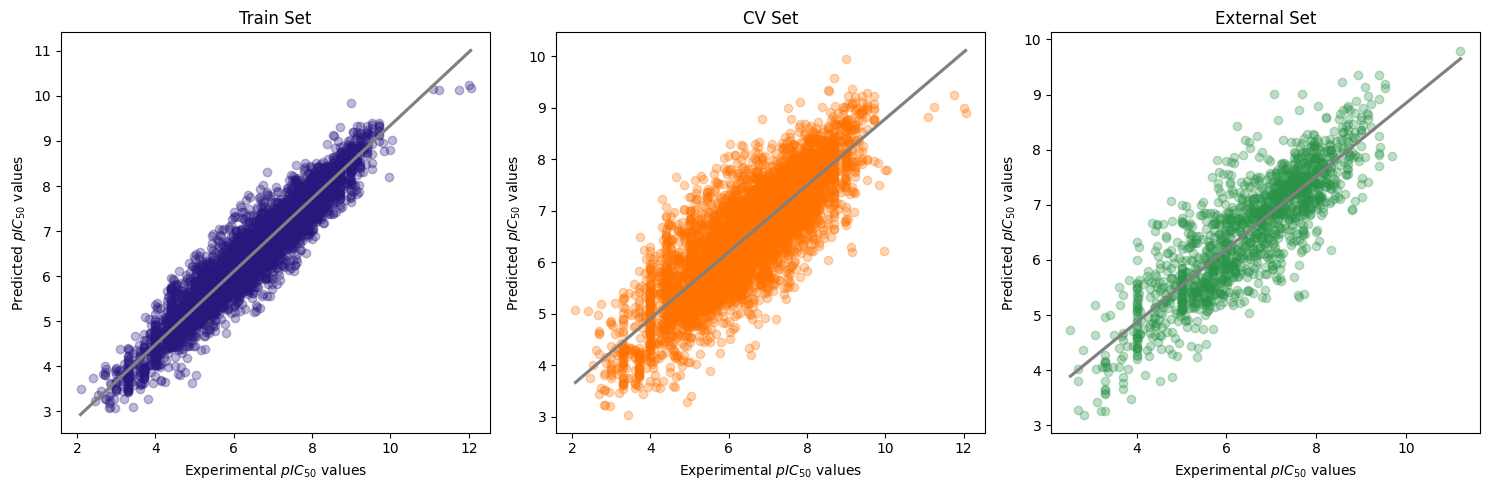

In [ ]:
# Build the model using filtered datasets
all_metrics_results, models, feature_importances_results, y_scrambling_results_external, y_scrambling_results_internal, rf = AD_build_model(
    X_internal_filtered,
    Y_internal_filtered,
    X_external_filtered,
    Y_external_filtered
)

# CSV for all metrics
pd.DataFrame(all_metrics_results).to_csv('/content/gdrive/Shareddrives/Thesis (PS4)/[01] Colab/[03] MV/KRC_AD_model_results_metrics.csv', index=False)

# CSV for feature importances
pd.DataFrame(feature_importances_results['importances_dict']).to_csv('/content/gdrive/Shareddrives/Thesis (PS4)/[01] Colab/[03] MV/KRC_AD_model_results_importances.csv', index=False)

print("Built model for a single DataFrame.")

In [ ]:
X_internal_filtered.to_csv('KRC_X_internal_filtered.csv')

##Applicability domain 2


###Dataset


In [ ]:
# Fit and predict using filtered datasets
rf_params = {
    'max_depth': 60,
    'max_features': 'sqrt',
    'min_samples_split': 4,
    'n_estimators': 940,
    'random_state': 42,
    'n_jobs': -1,
    'verbose': 1
}


rf_internal_AD2 = RandomForestRegressor(**rf_params)
rf_internal_AD2.fit(X_internal_filtered, Y_internal_filtered)

Y_internal_pred_filtered = rf_internal_AD2.predict(X_internal_filtered)
Y_external_pred_filtered = rf_internal_AD2.predict(X_external_filtered)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 196 tasks      | elapsed:    1.5s
[Parallel(n_jobs=-1)]: Done 446 tasks      | elapsed:    3.5s
[Parallel(n_jobs=-1)]: Done 796 tasks      | elapsed:    8.1s
[Parallel(n_jobs=-1)]: Done 940 out of 940 | elapsed:    9.2s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.1s
[Parallel(n_jobs=2)]: Done 196 tasks      | elapsed:    0.2s
[Parallel(n_jobs=2)]: Done 446 tasks      | elapsed:    0.5s
[Parallel(n_jobs=2)]: Done 796 tasks      | elapsed:    0.8s
[Parallel(n_jobs=2)]: Done 940 out of 940 | elapsed:    1.0s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done 196 tasks      | elapsed:    0.1s
[Par

###Leverage and William's plot - INTERNAL EXTERNAL

In [ ]:
# Calculate Mean Squared Error for internal and external datasets
mse_internal_filtered = mean_squared_error(Y_internal_filtered, Y_internal_pred_filtered)
mse_external_filtered = mean_squared_error(Y_external_filtered, Y_external_pred_filtered)

In [ ]:
# Calculate Standardized Residuals
std_residuals_internal_filtered = (Y_internal_filtered - Y_internal_pred_filtered) / np.sqrt(mse_internal_filtered)
std_residuals_external_filtered = (Y_external_filtered - Y_external_pred_filtered) / np.sqrt(mse_external_filtered)

std_residual_threshold = 3

In [ ]:
# Calculate Leverage (H) values
hat_matrix_internal_filtered = np.dot(X_internal_filtered, np.dot(np.linalg.inv(np.dot(X_internal_filtered.T, X_internal_filtered)), X_internal_filtered.T))
hat_matrix_external_filtered = np.dot(X_external_filtered, np.dot(np.linalg.inv(np.dot(X_internal_filtered.T, X_internal_filtered)), X_external_filtered.T))

leverage_internal_filtered = np.diag(hat_matrix_internal_filtered)
leverage_external_filtered = np.diag(hat_matrix_external_filtered)

In [ ]:
# Leverage threshold calculation
k = X_internal_filtered.shape[1] - 1
n = X_internal_filtered.shape[0]
leverage_threshold_filtered = 3 * (k + 1) / n
leverage_threshold_filtered

0.044055944055944055

In [ ]:
# Identify outliers based on leverage and standardized residuals
outliers_leverage_internal_filtered = leverage_internal_filtered > leverage_threshold_filtered
outliers_std_residual_internal_filtered = np.abs(std_residuals_internal_filtered) > std_residual_threshold

outliers_leverage_external_filtered = leverage_external_filtered > leverage_threshold_filtered
outliers_std_residual_external_filtered = np.abs(std_residuals_external_filtered) > std_residual_threshold

# Combine the conditions to identify outliers
outliers_internal_filtered = outliers_leverage_internal_filtered | outliers_std_residual_internal_filtered
outliers_external_filtered = outliers_leverage_external_filtered | outliers_std_residual_external_filtered

# Compute the number and percentage of outliers
num_outliers_internal_filtered = np.sum(outliers_internal_filtered)
num_outliers_external_filtered = np.sum(outliers_external_filtered)

percentage_outliers_internal_filtered = (num_outliers_internal_filtered / len(std_residuals_internal_filtered)) * 100
percentage_outliers_external_filtered = (num_outliers_external_filtered / len(std_residuals_external_filtered)) * 100

# Print the number and percentage of outliers
print(f"Number of Internal Outliers: {num_outliers_internal_filtered}, Percentage: {percentage_outliers_internal_filtered:.2f}%")
print(f"Number of External Outliers: {num_outliers_external_filtered}, Percentage: {percentage_outliers_external_filtered:.2f}%")

Number of Internal Outliers: 95, Percentage: 1.66%
Number of External Outliers: 22, Percentage: 1.54%


In [ ]:
# Identify compounds for outliers
compounds_internal_outliers_filtered = np.where(outliers_internal_filtered)[0]
compounds_external_outliers_filtered = np.where(outliers_external_filtered)[0]

# Print compounds and counts for internal and external outliers
print("\nCompounds for Internal Outliers:")
print(compounds_internal_outliers_filtered)
print("Count of Internal Outliers:", num_outliers_internal_filtered)

print("\nCompounds for External Outliers:")
print(compounds_external_outliers_filtered)
print("Count of External Outliers:", num_outliers_external_filtered)


percentage_outliers_internal_filtered = (num_outliers_internal_filtered / len(std_residuals_internal_filtered)) * 100
percentage_outliers_external_filtered = (num_outliers_external_filtered / len(std_residuals_external_filtered)) * 100

# Print the number and percentage of outliers
print(f"Percentage of Internal Outliers: {percentage_outliers_internal_filtered:.2f}%")
print(f"Percentage of External Outliers: {percentage_outliers_external_filtered:.2f}%")




Compounds for Internal Outliers:
[  25   45   92   95  205  228  244  279  300  390  419  500  569  630
  640  656  691  840  859  874  895 1222 1358 1381 1383 1456 1495 1615
 1726 1833 1887 1910 2034 2044 2102 2189 2203 2217 2225 2299 2325 2359
 2443 2470 2498 2557 2559 2688 2706 2759 3122 3151 3248 3256 3300 3327
 3416 3643 3650 3764 3791 3834 3941 3948 4025 4066 4096 4119 4228 4242
 4288 4324 4347 4376 4434 4533 4587 4668 4699 4743 4822 4826 4890 4902
 4987 5148 5179 5304 5525 5546 5564 5610 5628 5673 5716]
Count of Internal Outliers: 95

Compounds for External Outliers:
[   8  102  133  164  252  256  324  325  345  369  703  824  828  922
  960  977 1200 1306 1352 1381 1417 1428]
Count of External Outliers: 22
Percentage of Internal Outliers: 1.66%
Percentage of External Outliers: 1.54%


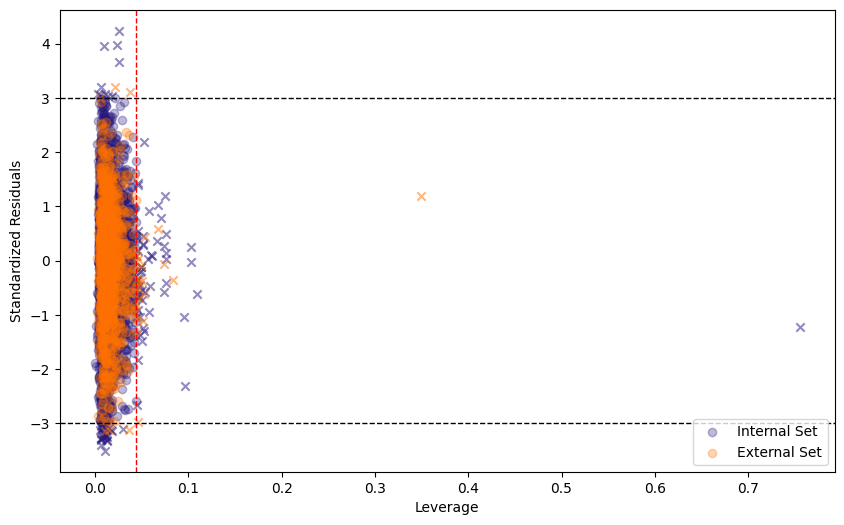

In [ ]:
# Plot
plt.figure(figsize=(10, 6))
plt.scatter(leverage_internal_filtered[~outliers_internal_filtered], std_residuals_internal_filtered[~outliers_internal_filtered], alpha=0.3, color='#27187eff', label='Internal Set')
plt.scatter(leverage_internal_filtered[outliers_internal_filtered], std_residuals_internal_filtered[outliers_internal_filtered], color='#27187eff', marker="x", alpha=0.5)
plt.scatter(leverage_external_filtered[~outliers_external_filtered], std_residuals_external_filtered[~outliers_external_filtered], alpha=0.3, color='#FF7200', label='External Set')
plt.scatter(leverage_external_filtered[outliers_external_filtered], std_residuals_external_filtered[outliers_external_filtered], color='#FF7200', marker="x", alpha=0.5)

plt.axvline(x=leverage_threshold_filtered, color='red', linestyle='--', linewidth=1)
plt.axhline(y=std_dev, color='black', linestyle='--', linewidth=1)
plt.axhline(y=-std_dev, color='black', linestyle='--', linewidth=1)

plt.xlabel('Leverage')
plt.ylabel('Standardized Residuals')
plt.legend(loc='lower right')

plt.savefig('KRC_AD2_williams_plot.png', dpi=300)
plt.show()


In [ ]:
compounds_internal_outliers_filtered = pd.DataFrame(compounds_internal_outliers_filtered)
compounds_internal_outliers_filtered.to_csv('compounds_internal_outliers_filtered.csv', index=False)
compounds_external_outliers_filtered = pd.DataFrame(compounds_external_outliers_filtered)
compounds_external_outliers_filtered.to_csv('compounds_external_outliers_filtered.csv', index=False)

#AD MODEL 2


## removing outliers

In [ ]:
# Create a boolean mask for internal and external outliers
mask_internal_outliers_2 = np.isin(np.arange(len(X_internal_filtered)), compounds_internal_outliers_filtered)
mask_external_outliers_2 = np.isin(np.arange(len(X_external_filtered)), compounds_external_outliers_filtered)

# Remove internal outliers from training set
X_internal_filtered_2 = X_internal_filtered[~mask_internal_outliers_2]
Y_internal_filtered_2 = Y_internal_filtered[~mask_internal_outliers_2]

# Remove external outliers from test set
X_external_filtered_2 = X_external_filtered[~mask_external_outliers_2]
Y_external_filtered_2 = Y_external_filtered[~mask_external_outliers_2]


In [ ]:
X_external_filtered_2.shape

(1411, 84)

In [ ]:
X_internal_filtered_2.shape

(5625, 84)

##AD Defining Functions


In [ ]:
def AD2_Y_scrambling(X_internal, X_external, Y_internal, Y_external, df_name):
    predictionOnExternal_scrambledtrain = []
    predictionOnInternal_scrambledtrain = []

    for randomseedcounter in range(1, 11):  # 10 iterations
        y_train_scrambled = deepcopy(Y_internal.values)
        X_train_scrambled = deepcopy(X_internal.values)

        np.random.shuffle(y_train_scrambled)
        np.random.shuffle(X_train_scrambled)

        RF_scrambled = RandomForestRegressor(max_depth=60,
                                             max_features='sqrt',
                                             min_samples_split=4,
                                             n_estimators=940,
                                             random_state=42,
                                             n_jobs=-1,
                                             verbose=1)  ## TO EDIT BASED FROM BEST HP

        RF_scrambled.fit(X_internal, y_train_scrambled)

        # Prediction on the external set
        y_predict_scrambled = RF_scrambled.predict(X_external)
        r2_test_scrambled = (RF_scrambled.score(X_external, Y_external))**2
        predictionOnExternal_scrambledtrain.append(r2_test_scrambled)

        # Prediction on the internal set
        y_predict_scrambled_predictTrain = RF_scrambled.predict(X_internal)
        r2_train_scrambled = (RF_scrambled.score(X_internal, Y_internal))**2
        predictionOnInternal_scrambledtrain.append(r2_train_scrambled)

    result = pd.DataFrame({
        'R2_scrambled': predictionOnInternal_scrambledtrain,
        'Q2_scrambled': predictionOnExternal_scrambledtrain
    })

    result.to_csv(f'AD2_Y_scrambling_results_{df_name}.csv', index=False)

    return predictionOnExternal_scrambledtrain, predictionOnInternal_scrambledtrain

In [ ]:
def AD2_plot_model(df_name, X_internal, X_external, Y_internal, Y_external, rf, hx):
    # Prepare plot
    fig_size = plt.rcParams["figure.figsize"]
    fig_size[0] = 15
    fig_size[1] = 5

    # Train Set
    plt.subplot(1, 3, 1)
    m = rf.fit(X_internal, Y_internal)
    x_train = np.array(Y_internal)
    y_train = m.predict(X_internal).flatten()
    sns.regplot(x=x_train, y=y_train, scatter_kws={'color': '#27187eff', 'alpha': 0.3}, line_kws={'color': 'gray'}, ci=None)
    plt.xlabel("Experimental $pIC_{50}$ values", fontsize=10)
    plt.ylabel("Predicted $pIC_{50}$ values", fontsize=10)
    plt.title("Train Set")

    # CV Set
    plt.subplot(1, 3, 2)
    cv = cross_val_predict(rf, X_internal, Y_internal, cv=10, n_jobs=-1)
    x_test = np.array(Y_internal)
    y_test = cv
    sns.regplot(x=x_test, y=y_test, scatter_kws={'color': '#FF7200', 'alpha': 0.3}, line_kws={'color': 'gray'}, ci=None)
    plt.xlabel("Experimental $pIC_{50}$ values", fontsize=10)
    plt.ylabel("Predicted $pIC_{50}$ values", fontsize=10)
    plt.title("CV Set")

    # External Set
    plt.subplot(1, 3, 3)
    x_test = np.array(Y_external)
    y_test = m.predict(X_external).flatten()
    sns.regplot(x=x_test, y=y_test, scatter_kws={'color': '#2b9348', 'alpha': 0.3}, line_kws={'color': 'gray'}, ci=None)
    plt.xlabel("Experimental $pIC_{50}$ values", fontsize=10)
    plt.ylabel("Predicted $pIC_{50}$ values", fontsize=10)
    plt.title("External Set")

    plt.tight_layout()
    plt.savefig(f'AD2_{df_name}_compare.png', dpi=300)

In [ ]:
def AD2_build_model(X_internal, Y_internal, X_external, Y_external, config=None):
    if config is None:
        config = {
            'hx': X_internal.columns.tolist(),
            'df_name': 'KlekotaRothCount',
            'rf_params': {
                'max_depth': 60,
                'max_features': 'sqrt',
                'min_samples_split': 4,
                'n_estimators': 940,
                'random_state': 42,
                'n_jobs': -1,
                'verbose': 1
            }
        }

    models = []
    all_metrics_results = {
        'MAE_train': [],
        'R2_train': [],
        'RMSE_train': [],
        'MAE_CV': [],
        'Q2_CV': [],
        'RMSE_CV': [],
        'MAE_External': [],
        'Q2_External': [],
        'RMSE_External': []
    }

    # Extracting parameters from the config dictionary
    hx = config['hx']
    df_name = config['df_name']
    rf_params = config['rf_params']

    feature_importances_results = {
        'importances_dict': defaultdict(list)
    }

    y_scrambling_results_external = []
    y_scrambling_results_internal = []

    # Internal set
    rf = RandomForestRegressor(**rf_params)
    rf.fit(X_internal, Y_internal)
    prediction_internal = rf.predict(X_internal)

    # Cross-validation
    cv = cross_val_predict(rf, X_internal, Y_internal, cv=10, n_jobs=-1)

    # External set
    prediction_external = rf.predict(X_external)

    # Save the trained model using joblib
    model_filename = f'AD2_trained_model_{df_name}.joblib'
    joblib.dump(rf, model_filename)

    # Append the model to the list
    models.append(model_filename)

    # Store results for the single split
    all_metrics_results['MAE_train'].append(mean_absolute_error(Y_internal, prediction_internal))
    all_metrics_results['R2_train'].append(r2_score(Y_internal, prediction_internal))
    all_metrics_results['RMSE_train'].append(np.sqrt(mean_squared_error(Y_internal, prediction_internal)))
    all_metrics_results['MAE_CV'].append(mean_absolute_error(Y_internal, cv))
    all_metrics_results['Q2_CV'].append(r2_score(Y_internal, cv))
    all_metrics_results['RMSE_CV'].append(np.sqrt(mean_squared_error(Y_internal, cv)))
    all_metrics_results['MAE_External'].append(mean_absolute_error(Y_external, prediction_external))
    all_metrics_results['Q2_External'].append(r2_score(Y_external, prediction_external))
    all_metrics_results['RMSE_External'].append(np.sqrt(mean_squared_error(Y_external, prediction_external)))

    # Feature Importance
    feature_importance = rf.feature_importances_
    importances = list(zip(hx, feature_importance))
    importances = sorted(importances, key=lambda x: x[1], reverse=True)

    # Feature importance Visualization
    fig_size = plt.rcParams["figure.figsize"]
    fig_size[0] = 5
    fig_size[1] = 10

    barlist = plt.barh(range(20), [x[1] for x in importances[:20]],
                      color="#27187eff", xerr=[x[1] for x in importances[:20]],
                      align="center", error_kw=dict(ecolor='gray', lw=2, capsize=5, capthick=2))

    plt.yticks(range(20), [x[0] for x in importances[:20]])
    plt.ylim([-1, 20])

    plt.xlabel(r"$\bf{Gini}$" + " " + r"$\bf{index}$", fontsize=12)
    ax = plt.gca()
    ax.invert_yaxis()
    plt.tight_layout(pad=2.0, w_pad=0.7, h_pad=2.0)

    # Save the feature importance plot
    plt.savefig(f'AD2_{df_name}_Feature_importances.png', dpi=300)
    plt.close()

    # Store feature importances
    for i, fx in enumerate(hx):
        feature_importances_results['importances_dict'][fx].append(feature_importance[i])

    # Y Scrambling
    y_scrambling_results_internal_split, y_scrambling_results_external_split = AD2_Y_scrambling(X_internal, X_external, Y_internal, Y_external, df_name)

    y_scrambling_results_external.append(y_scrambling_results_external_split)
    y_scrambling_results_internal.append(y_scrambling_results_internal_split)

    # Plotting
    AD2_plot_model(df_name, X_internal, X_external, Y_internal, Y_external, rf, hx)

    return (
        all_metrics_results,
        models,
        feature_importances_results,
        y_scrambling_results_external,
        y_scrambling_results_internal,
        rf)


##Running all the defined functions

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 196 tasks      | elapsed:    1.5s
[Parallel(n_jobs=-1)]: Done 446 tasks      | elapsed:    3.4s
[Parallel(n_jobs=-1)]: Done 796 tasks      | elapsed:    7.3s
[Parallel(n_jobs=-1)]: Done 940 out of 940 | elapsed:    8.8s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done 196 tasks      | elapsed:    0.2s
[Parallel(n_jobs=2)]: Done 446 tasks      | elapsed:    0.4s
[Parallel(n_jobs=2)]: Done 796 tasks      | elapsed:    0.8s
[Parallel(n_jobs=2)]: Done 940 out of 940 | elapsed:    0.9s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done 196 tasks      | elapsed:    0.1s
[Par

Built model for a single DataFrame.


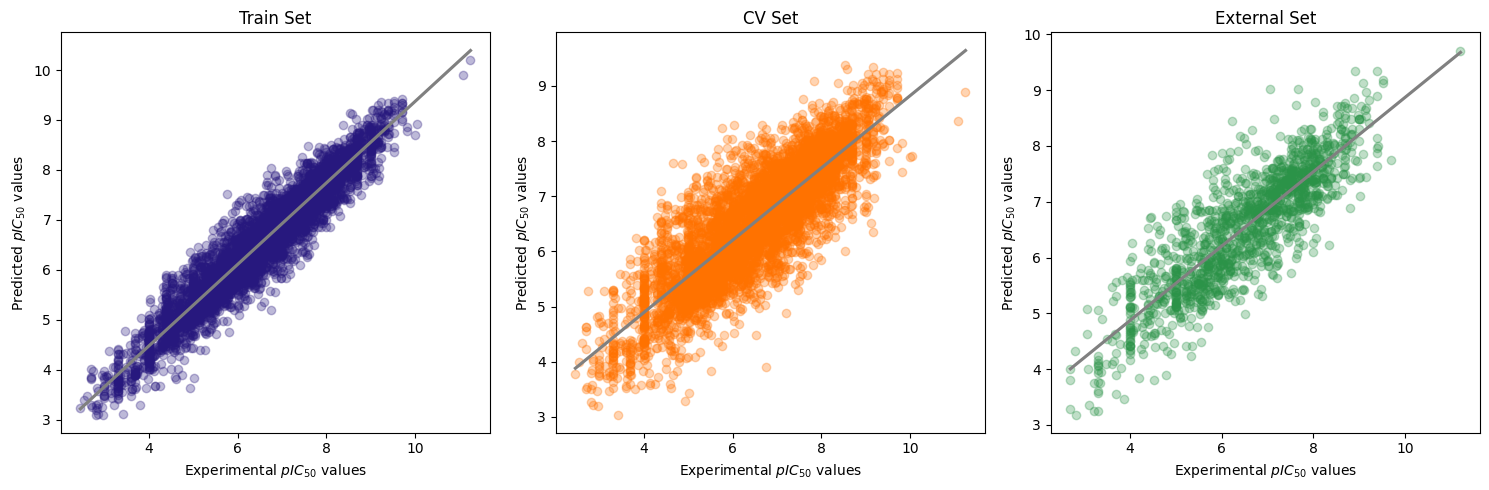

In [ ]:
# Build the model using filtered datasets
all_metrics_results, models, feature_importances_results, y_scrambling_results_external, y_scrambling_results_internal, rf = AD2_build_model(
    X_internal_filtered_2,
    Y_internal_filtered_2,
    X_external_filtered_2,
    Y_external_filtered_2
)

# CSV for all metrics
pd.DataFrame(all_metrics_results).to_csv('/content/gdrive/Shareddrives/Thesis (PS4)/[01] Colab/[03] MV/KRC_AD2_model_results_metrics.csv', index=False)

# CSV for feature importances
pd.DataFrame(feature_importances_results['importances_dict']).to_csv('/content/gdrive/Shareddrives/Thesis (PS4)/[01] Colab/[03] MV/KRC_AD2_model_results_importances.csv', index=False)

print("Built model for a single DataFrame.")

In [ ]:
X_internal_filtered.to_csv('KRC_X_internal_filtered2.csv')

In [ ]:
# Fit and predict using filtered datasets
rf_params = {
    'max_depth': 60,
    'max_features': 'sqrt',
    'min_samples_split': 4,
    'n_estimators': 940,
    'random_state': 42,
    'n_jobs': -1,
    'verbose': 1
}


rf_internal_AD2 = RandomForestRegressor(**rf_params)
rf_internal_AD2.fit(X_internal_filtered_2, Y_internal_filtered_2)

Y_internal_pred_filtered_2 = rf_internal_AD2.predict(X_internal_filtered_2)
Y_external_pred_filtered_2 = rf_internal_AD2.predict(X_external_filtered_2)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done 196 tasks      | elapsed:    1.9s
[Parallel(n_jobs=-1)]: Done 446 tasks      | elapsed:    3.8s
[Parallel(n_jobs=-1)]: Done 796 tasks      | elapsed:    6.5s
[Parallel(n_jobs=-1)]: Done 940 out of 940 | elapsed:    7.7s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.1s
[Parallel(n_jobs=2)]: Done 196 tasks      | elapsed:    0.2s
[Parallel(n_jobs=2)]: Done 446 tasks      | elapsed:    0.5s
[Parallel(n_jobs=2)]: Done 796 tasks      | elapsed:    0.8s
[Parallel(n_jobs=2)]: Done 940 out of 940 | elapsed:    0.9s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done 196 tasks      | elapsed:    0.1s
[Par

##Applicability domain 3


In [ ]:
# Calculate Mean Squared Error for internal and external datasets
mse_internal_filtered_2 = mean_squared_error(Y_internal_filtered_2, Y_internal_pred_filtered_2)
mse_external_filtered_2 = mean_squared_error(Y_external_filtered_2, Y_external_pred_filtered_2)

In [ ]:
# Calculate Standardized Residuals
std_residuals_internal_filtered_2 = (Y_internal_filtered_2 - Y_internal_pred_filtered_2) / np.sqrt(mse_internal_filtered_2)
std_residuals_external_filtered_2 = (Y_external_filtered_2 - Y_external_pred_filtered_2) / np.sqrt(mse_external_filtered_2)

std_residual_threshold = 3

In [ ]:
# Calculate Leverage (H) values using pseudo-inverse
hat_matrix_internal_filtered_2 = np.dot(X_internal_filtered_2, np.dot(np.linalg.pinv(np.dot(X_internal_filtered_2.T, X_internal_filtered_2)), X_internal_filtered_2.T))
hat_matrix_external_filtered_2 = np.dot(X_external_filtered_2, np.dot(np.linalg.pinv(np.dot(X_internal_filtered_2.T, X_internal_filtered_2)), X_external_filtered_2.T))

leverage_internal_filtered_2 = np.diag(hat_matrix_internal_filtered_2)
leverage_external_filtered_2 = np.diag(hat_matrix_external_filtered_2)


In [ ]:
# Leverage threshold calculation
k = X_internal_filtered_2.shape[1] - 1
n = X_internal_filtered_2.shape[0]
leverage_threshold_filtered_2 = 3 * (k + 1) / n
leverage_threshold_filtered_2

0.0448

0.0448

In [ ]:
# Identify outliers based on leverage and standardized residuals
outliers_leverage_internal_filtered_2 = leverage_internal_filtered_2 > leverage_threshold_filtered_2
outliers_std_residual_internal_filtered_2 = np.abs(std_residuals_internal_filtered_2) > std_residual_threshold

outliers_leverage_external_filtered_2 = leverage_external_filtered_2 > leverage_threshold_filtered_2
outliers_std_residual_external_filtered_2 = np.abs(std_residuals_external_filtered_2) > std_residual_threshold

# Combine the conditions to identify outliers
outliers_internal_filtered_2 = outliers_leverage_internal_filtered_2 | outliers_std_residual_internal_filtered_2
outliers_external_filtered_2 = outliers_leverage_external_filtered_2 | outliers_std_residual_external_filtered_2

# Compute the number and percentage of outliers
num_outliers_internal_filtered_2 = np.sum(outliers_internal_filtered_2)
num_outliers_external_filtered_2 = np.sum(outliers_external_filtered_2)

percentage_outliers_internal_filtered_2 = (num_outliers_internal_filtered_2 / len(std_residuals_internal_filtered_2)) * 100
percentage_outliers_external_filtered_2 = (num_outliers_external_filtered_2 / len(std_residuals_external_filtered_2)) * 100

# Print the number and percentage of outliers
print(f"Number of Internal Outliers: {num_outliers_internal_filtered_2}, Percentage: {percentage_outliers_internal_filtered_2:.2f}%")
print(f"Number of External Outliers: {num_outliers_external_filtered_2}, Percentage: {percentage_outliers_external_filtered_2:.2f}%")

Number of Internal Outliers: 68, Percentage: 1.21%
Number of External Outliers: 13, Percentage: 0.92%


Number of Internal Outliers: 68, Percentage: 1.21%
Number of External Outliers: 13, Percentage: 0.92%

In [ ]:
# List compounds for outliers
compounds_internal_outliers_filtered_2 = np.where(outliers_internal_filtered_2)[0]
compounds_external_outliers_filtered_2 = np.where(outliers_external_filtered_2)[0]

# Print compounds and counts for internal and external outliers
print("\nCompounds for Internal Outliers:")
print(compounds_internal_outliers_filtered_2)
print("Count of Internal Outliers:", num_outliers_internal_filtered_2)

print("\nCompounds for External Outliers:")
print(compounds_external_outliers_filtered_2)
print("Count of External Outliers:", num_outliers_external_filtered_2)


percentage_outliers_internal_filtered_2 = (num_outliers_internal_filtered_2 / len(std_residuals_internal_filtered_2)) * 100
percentage_outliers_external_filtered_2 = (num_outliers_external_filtered_2 / len(std_residuals_external_filtered_2)) * 100

# Print the number and percentage of outliers
print(f"Percentage of Internal Outliers: {percentage_outliers_internal_filtered_2:.2f}%")
print(f"Percentage of External Outliers: {percentage_outliers_external_filtered_2:.2f}%")



Compounds for Internal Outliers:
[  91  108  217  247  349  384  403  452  551  679  684  739  781  833
  862  881  933  987 1109 1115 1195 1245 1254 1389 1531 1646 1835 1909
 1963 2141 2176 2180 2219 2308 2324 2397 2432 2766 2806 3088 3126 3138
 3307 3368 3369 3479 3551 3557 3677 3857 3893 3997 4146 4262 4332 4405
 4433 4532 4773 4894 5129 5234 5237 5405 5425 5456 5467 5613]
Count of Internal Outliers: 68

Compounds for External Outliers:
[   6  177  417  570  880  915 1008 1027 1085 1103 1237 1310 1370]
Count of External Outliers: 13
Percentage of Internal Outliers: 1.21%
Percentage of External Outliers: 0.92%


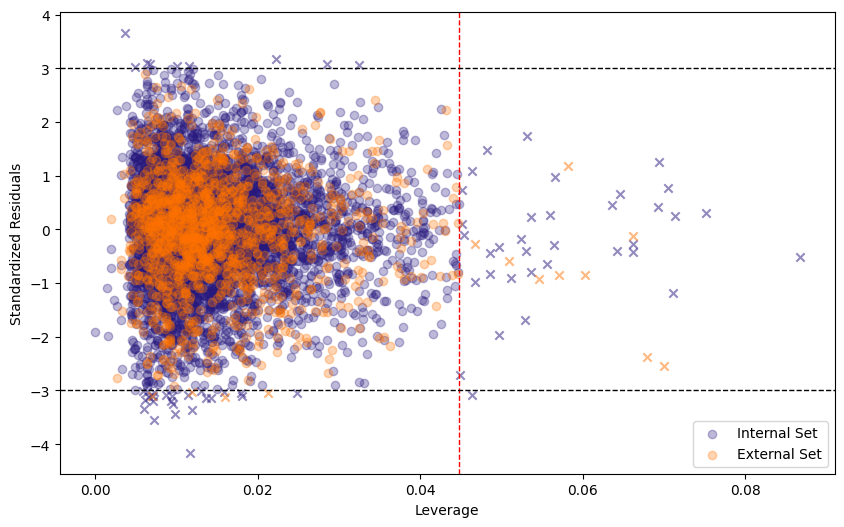

In [ ]:
# Plot
plt.figure(figsize=(10, 6))
plt.scatter(leverage_internal_filtered_2[~outliers_internal_filtered_2], std_residuals_internal_filtered_2[~outliers_internal_filtered_2], alpha=0.3, color='#27187eff', label='Internal Set')
plt.scatter(leverage_internal_filtered_2[outliers_internal_filtered_2], std_residuals_internal_filtered_2[outliers_internal_filtered_2], color='#27187eff', marker="x", alpha=0.5)
plt.scatter(leverage_external_filtered_2[~outliers_external_filtered_2], std_residuals_external_filtered_2[~outliers_external_filtered_2], alpha=0.3, color='#FF7200', label='External Set')
plt.scatter(leverage_external_filtered_2[outliers_external_filtered_2], std_residuals_external_filtered_2[outliers_external_filtered_2], color='#FF7200', marker="x", alpha=0.5)

plt.axvline(x=leverage_threshold_filtered_2, color='red', linestyle='--', linewidth=1)
plt.axhline(y=std_dev, color='black', linestyle='--', linewidth=1)
plt.axhline(y=-std_dev, color='black', linestyle='--', linewidth=1)

plt.xlabel('Leverage')
plt.ylabel('Standardized Residuals')
plt.legend(loc='lower right')

plt.savefig('KRC_AD3_williams_plot.png', dpi=300)
plt.show()


In [ ]:
compounds_internal_outliers_filtered_2 = pd.DataFrame(compounds_internal_outliers_filtered_2)
compounds_internal_outliers_filtered_2.to_csv('compounds_internal_outliers_filtered_2.csv', index=False)
compounds_external_outliers_filtered_2 = pd.DataFrame(compounds_external_outliers_filtered_2)
compounds_external_outliers_filtered_2.to_csv('compounds_external_outliers_filtered_2.csv', index=False)

#AD MODEL 3


##removing outliers

In [ ]:
# Create a boolean mask for internal and external outliers
mask_internal_outliers_3 = np.isin(np.arange(len(X_internal_filtered_2)), compounds_internal_outliers_filtered_2)
mask_external_outliers_3 = np.isin(np.arange(len(X_external_filtered_2)), compounds_external_outliers_filtered_2)

# Remove internal outliers from training set
X_internal_filtered_3 = X_internal_filtered_2[~mask_internal_outliers_3]
Y_internal_filtered_3 = Y_internal_filtered_2[~mask_internal_outliers_3]

# Remove external outliers from test set
X_external_filtered_3 = X_external_filtered_2[~mask_external_outliers_3]
Y_external_filtered_3 = Y_external_filtered_2[~mask_external_outliers_3]


##AD Defining Functions


In [ ]:
def AD3_Y_scrambling(X_internal, X_external, Y_internal, Y_external, df_name):
    predictionOnExternal_scrambledtrain = []
    predictionOnInternal_scrambledtrain = []

    for randomseedcounter in range(1, 11):  # 10 iterations
        y_train_scrambled = deepcopy(Y_internal.values)
        X_train_scrambled = deepcopy(X_internal.values)

        np.random.shuffle(y_train_scrambled)
        np.random.shuffle(X_train_scrambled)

        RF_scrambled = RandomForestRegressor(max_depth=60,
                                             max_features='sqrt',
                                             min_samples_split=4,
                                             n_estimators=940,
                                             random_state=42,
                                             n_jobs=-1,
                                             verbose=1)  ## TO EDIT BASED FROM BEST HP

        RF_scrambled.fit(X_internal, y_train_scrambled)

        # Prediction on the external set
        y_predict_scrambled = RF_scrambled.predict(X_external)
        r2_test_scrambled = (RF_scrambled.score(X_external, Y_external))**2
        predictionOnExternal_scrambledtrain.append(r2_test_scrambled)

        # Prediction on the internal set
        y_predict_scrambled_predictTrain = RF_scrambled.predict(X_internal)
        r2_train_scrambled = (RF_scrambled.score(X_internal, Y_internal))**2
        predictionOnInternal_scrambledtrain.append(r2_train_scrambled)

    result = pd.DataFrame({
        'R2_scrambled': predictionOnInternal_scrambledtrain,
        'Q2_scrambled': predictionOnExternal_scrambledtrain
    })

    result.to_csv(f'AD3_Y_scrambling_results_{df_name}.csv', index=False)

    return predictionOnExternal_scrambledtrain, predictionOnInternal_scrambledtrain

In [ ]:
def AD3_plot_model(df_name, X_internal, X_external, Y_internal, Y_external, rf, hx):
    # Prepare plot
    fig_size = plt.rcParams["figure.figsize"]
    fig_size[0] = 15
    fig_size[1] = 5

    # Train Set
    plt.subplot(1, 3, 1)
    m = rf.fit(X_internal, Y_internal)
    x_train = np.array(Y_internal)
    y_train = m.predict(X_internal).flatten()
    sns.regplot(x=x_train, y=y_train, scatter_kws={'color': '#27187eff', 'alpha': 0.3}, line_kws={'color': 'gray'}, ci=None)
    plt.xlabel("Experimental $pIC_{50}$ values", fontsize=10)
    plt.ylabel("Predicted $pIC_{50}$ values", fontsize=10)
    plt.title("Train Set")

    # CV Set
    plt.subplot(1, 3, 2)
    cv = cross_val_predict(rf, X_internal, Y_internal, cv=10, n_jobs=-1)
    x_test = np.array(Y_internal)
    y_test = cv
    sns.regplot(x=x_test, y=y_test, scatter_kws={'color': '#FF7200', 'alpha': 0.3}, line_kws={'color': 'gray'}, ci=None)
    plt.xlabel("Experimental $pIC_{50}$ values", fontsize=10)
    plt.ylabel("Predicted $pIC_{50}$ values", fontsize=10)
    plt.title("CV Set")

    # External Set
    plt.subplot(1, 3, 3)
    x_test = np.array(Y_external)
    y_test = m.predict(X_external).flatten()
    sns.regplot(x=x_test, y=y_test, scatter_kws={'color': '#2b9348', 'alpha': 0.3}, line_kws={'color': 'gray'}, ci=None)
    plt.xlabel("Experimental $pIC_{50}$ values", fontsize=10)
    plt.ylabel("Predicted $pIC_{50}$ values", fontsize=10)
    plt.title("External Set")

    plt.tight_layout()
    plt.savefig(f'AD3_{df_name}_compare.png', dpi=300)

In [ ]:
def AD3_build_model(X_internal, Y_internal, X_external, Y_external, config=None):
    if config is None:
        config = {
            'hx': X_internal.columns.tolist(),
            'df_name': 'KlekotaRothCount',
            'rf_params': {
                'max_depth': 60,
                'max_features': 'sqrt',
                'min_samples_split': 4,
                'n_estimators': 940,
                'random_state': 42,
                'n_jobs': -1,
                'verbose': 1
            }
        }

    models = []
    all_metrics_results = {
        'MAE_train': [],
        'R2_train': [],
        'RMSE_train': [],
        'MAE_CV': [],
        'Q2_CV': [],
        'RMSE_CV': [],
        'MAE_External': [],
        'Q2_External': [],
        'RMSE_External': []
    }

    # Extracting parameters from the config dictionary
    hx = config['hx']
    df_name = config['df_name']
    rf_params = config['rf_params']

    feature_importances_results = {
        'importances_dict': defaultdict(list)
    }

    y_scrambling_results_external = []
    y_scrambling_results_internal = []

    # Internal set
    rf = RandomForestRegressor(**rf_params)
    rf.fit(X_internal, Y_internal)
    prediction_internal = rf.predict(X_internal)

    # Cross-validation
    cv = cross_val_predict(rf, X_internal, Y_internal, cv=10, n_jobs=-1)

    # External set
    prediction_external = rf.predict(X_external)

    # Save the trained model using joblib
    model_filename = f'AD3_trained_model_{df_name}.joblib'
    joblib.dump(rf, model_filename)

    # Append the model to the list
    models.append(model_filename)

    # Store results for the single split
    all_metrics_results['MAE_train'].append(mean_absolute_error(Y_internal, prediction_internal))
    all_metrics_results['R2_train'].append(r2_score(Y_internal, prediction_internal))
    all_metrics_results['RMSE_train'].append(np.sqrt(mean_squared_error(Y_internal, prediction_internal)))
    all_metrics_results['MAE_CV'].append(mean_absolute_error(Y_internal, cv))
    all_metrics_results['Q2_CV'].append(r2_score(Y_internal, cv))
    all_metrics_results['RMSE_CV'].append(np.sqrt(mean_squared_error(Y_internal, cv)))
    all_metrics_results['MAE_External'].append(mean_absolute_error(Y_external, prediction_external))
    all_metrics_results['Q2_External'].append(r2_score(Y_external, prediction_external))
    all_metrics_results['RMSE_External'].append(np.sqrt(mean_squared_error(Y_external, prediction_external)))

    # Feature Importance
    feature_importance = rf.feature_importances_
    importances = list(zip(hx, feature_importance))
    importances = sorted(importances, key=lambda x: x[1], reverse=True)

    # Feature importance Visualization
    fig_size = plt.rcParams["figure.figsize"]
    fig_size[0] = 5
    fig_size[1] = 10

    barlist = plt.barh(range(20), [x[1] for x in importances[:20]],
                      color="#27187eff", xerr=[x[1] for x in importances[:20]],
                      align="center", error_kw=dict(ecolor='gray', lw=2, capsize=5, capthick=2))

    plt.yticks(range(20), [x[0] for x in importances[:20]])
    plt.ylim([-1, 20])

    plt.xlabel(r"$\bf{Gini}$" + " " + r"$\bf{index}$", fontsize=12)
    ax = plt.gca()
    ax.invert_yaxis()
    plt.tight_layout(pad=2.0, w_pad=0.7, h_pad=2.0)

    # Save the feature importance plot
    plt.savefig(f'AD3_{df_name}_Feature_importances.png', dpi=300)
    plt.close()

    # Store feature importances
    for i, fx in enumerate(hx):
        feature_importances_results['importances_dict'][fx].append(feature_importance[i])

    # Y Scrambling
    y_scrambling_results_internal_split, y_scrambling_results_external_split = AD3_Y_scrambling(X_internal, X_external, Y_internal, Y_external, df_name)

    y_scrambling_results_external.append(y_scrambling_results_external_split)
    y_scrambling_results_internal.append(y_scrambling_results_internal_split)

    # Plotting
    AD3_plot_model(df_name, X_internal, X_external, Y_internal, Y_external, rf, hx)

    return (
        all_metrics_results,
        models,
        feature_importances_results,
        y_scrambling_results_external,
        y_scrambling_results_internal,
        rf)


##Running all the defined functions

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 196 tasks      | elapsed:    1.4s
[Parallel(n_jobs=-1)]: Done 446 tasks      | elapsed:    3.3s
[Parallel(n_jobs=-1)]: Done 796 tasks      | elapsed:    7.0s
[Parallel(n_jobs=-1)]: Done 940 out of 940 | elapsed:    8.7s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done 196 tasks      | elapsed:    0.2s
[Parallel(n_jobs=2)]: Done 446 tasks      | elapsed:    0.5s
[Parallel(n_jobs=2)]: Done 796 tasks      | elapsed:    0.8s
[Parallel(n_jobs=2)]: Done 940 out of 940 | elapsed:    0.9s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done 196 tasks      | elapsed:    0.1s
[Par

Built model for a single DataFrame.


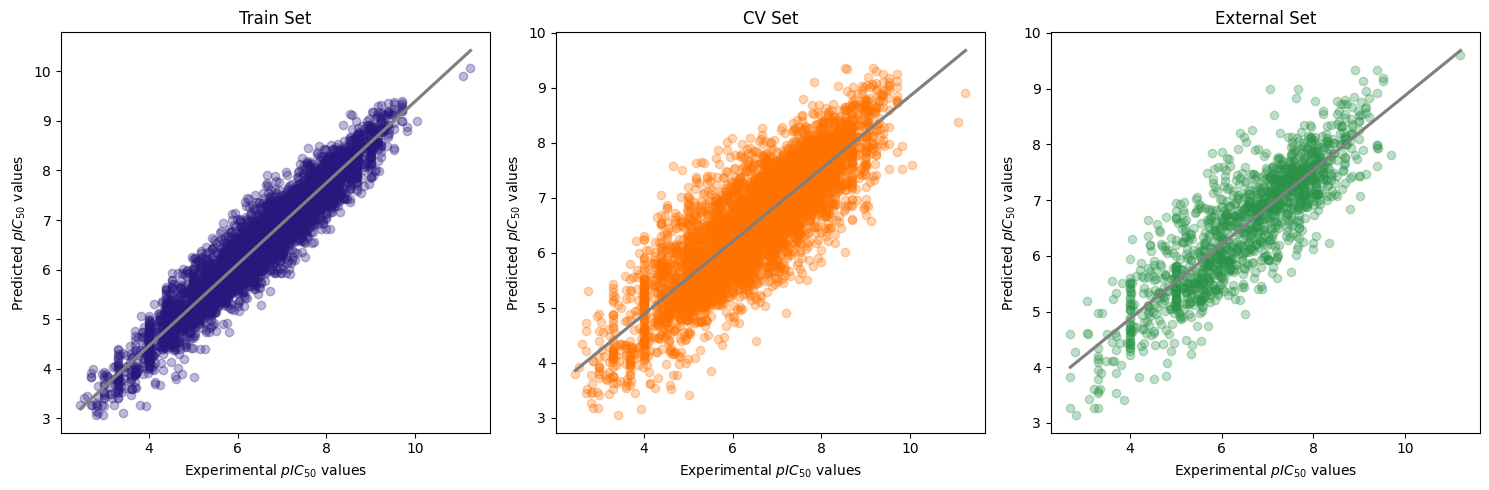

In [ ]:
# Build the model using filtered datasets
all_metrics_results, models, feature_importances_results, y_scrambling_results_external, y_scrambling_results_internal, rf = AD3_build_model(
    X_internal_filtered_3,
    Y_internal_filtered_3,
    X_external_filtered_3,
    Y_external_filtered_3
)

# CSV for all metrics
pd.DataFrame(all_metrics_results).to_csv('/content/gdrive/Shareddrives/Thesis (PS4)/[01] Colab/[03] MV/KRC_AD3_model_results_metrics.csv', index=False)

# CSV for feature importances
pd.DataFrame(feature_importances_results['importances_dict']).to_csv('/content/gdrive/Shareddrives/Thesis (PS4)/[01] Colab/[03] MV/KRC_AD3_model_results_importances.csv', index=False)

print("Built model for a single DataFrame.")

## Applicability domain 4


In [ ]:
# Fit and predict using filtered datasets
rf_params = {
    'max_depth': 60,
    'max_features': 'sqrt',
    'min_samples_split': 4,
    'n_estimators': 940,
    'random_state': 42,
    'n_jobs': -1,
    'verbose': 1
}


rf_internal_AD3 = RandomForestRegressor(**rf_params)
rf_internal_AD3.fit(X_internal_filtered_3, Y_internal_filtered_3)

Y_internal_pred_filtered_3 = rf_internal_AD3.predict(X_internal_filtered_3)
Y_external_pred_filtered_3 = rf_internal_AD3.predict(X_external_filtered_3)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 196 tasks      | elapsed:    1.5s
[Parallel(n_jobs=-1)]: Done 446 tasks      | elapsed:    3.3s
[Parallel(n_jobs=-1)]: Done 796 tasks      | elapsed:    6.3s
[Parallel(n_jobs=-1)]: Done 940 out of 940 | elapsed:    8.2s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.1s
[Parallel(n_jobs=2)]: Done 196 tasks      | elapsed:    0.4s
[Parallel(n_jobs=2)]: Done 446 tasks      | elapsed:    0.8s
[Parallel(n_jobs=2)]: Done 796 tasks      | elapsed:    1.3s
[Parallel(n_jobs=2)]: Done 940 out of 940 | elapsed:    1.4s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done 196 tasks      | elapsed:    0.1s
[Par

In [ ]:
# Calculate Mean Squared Error for internal and external datasets
mse_internal_filtered_3 = mean_squared_error(Y_internal_filtered_3, Y_internal_pred_filtered_3)
mse_external_filtered_3 = mean_squared_error(Y_external_filtered_3, Y_external_pred_filtered_3)

In [ ]:
# Calculate Standardized Residuals
std_residuals_internal_filtered_3 = (Y_internal_filtered_3 - Y_internal_pred_filtered_3) / np.sqrt(mse_internal_filtered_3)
std_residuals_external_filtered_3 = (Y_external_filtered_3 - Y_external_pred_filtered_3) / np.sqrt(mse_external_filtered_3)

std_residual_threshold = 3

In [ ]:
# Calculate Leverage (H) values using pseudo-inverse
hat_matrix_internal_filtered_3 = np.dot(X_internal_filtered_3, np.dot(np.linalg.pinv(np.dot(X_internal_filtered_3.T, X_internal_filtered_3)), X_internal_filtered_3.T))
hat_matrix_external_filtered_3 = np.dot(X_external_filtered_3, np.dot(np.linalg.pinv(np.dot(X_internal_filtered_3.T, X_internal_filtered_3)), X_external_filtered_3.T))

leverage_internal_filtered_3 = np.diag(hat_matrix_internal_filtered_3)
leverage_external_filtered_3 = np.diag(hat_matrix_external_filtered_3)


In [ ]:
# Leverage threshold calculation
k = X_internal_filtered_3.shape[1] - 1
n = X_internal_filtered_3.shape[0]
leverage_threshold_filtered_3 = 3 * (k + 1) / n
leverage_threshold_filtered_3

0.04534820946553896

0.04534820946553896

In [ ]:
# Identify outliers based on leverage and standardized residuals
outliers_leverage_internal_filtered_3 = leverage_internal_filtered_3 > leverage_threshold_filtered_3
outliers_std_residual_internal_filtered_3 = np.abs(std_residuals_internal_filtered_3) > std_residual_threshold

outliers_leverage_external_filtered_3 = leverage_external_filtered_3 > leverage_threshold_filtered_3
outliers_std_residual_external_filtered_3 = np.abs(std_residuals_external_filtered_3) > std_residual_threshold

# Combine the conditions to identify outliers
outliers_internal_filtered_3 = outliers_leverage_internal_filtered_3 | outliers_std_residual_internal_filtered_3
outliers_external_filtered_3 = outliers_leverage_external_filtered_3 | outliers_std_residual_external_filtered_3

# Compute the number and percentage of outliers
num_outliers_internal_filtered_3 = np.sum(outliers_internal_filtered_3)
num_outliers_external_filtered_3 = np.sum(outliers_external_filtered_3)

percentage_outliers_internal_filtered_3 = (num_outliers_internal_filtered_3 / len(std_residuals_internal_filtered_3)) * 100
percentage_outliers_external_filtered_3 = (num_outliers_external_filtered_3 / len(std_residuals_external_filtered_3)) * 100

# Print the number and percentage of outliers
print(f"Number of Internal Outliers: {num_outliers_internal_filtered_3}, Percentage: {percentage_outliers_internal_filtered_3:.2f}%")
print(f"Number of External Outliers: {num_outliers_external_filtered_3}, Percentage: {percentage_outliers_external_filtered_3:.2f}%")

Number of Internal Outliers: 43, Percentage: 0.77%
Number of External Outliers: 9, Percentage: 0.64%


Number of Internal Outliers: 43, Percentage: 0.77%
Number of External Outliers: 9, Percentage: 0.64%

In [ ]:
# List compounds for outliers
compounds_internal_outliers_filtered_3 = np.where(outliers_internal_filtered_3)[0]
compounds_external_outliers_filtered_3 = np.where(outliers_external_filtered_3)[0]

# Print compounds and counts for internal and external outliers
print("\nCompounds for Internal Outliers:")
print(compounds_internal_outliers_filtered_3)
print("Count of Internal Outliers:", num_outliers_internal_filtered_3)

print("\nCompounds for External Outliers:")
print(compounds_external_outliers_filtered_3)
print("Count of External Outliers:", num_outliers_external_filtered_3)


percentage_outliers_internal_filtered_3 = (num_outliers_internal_filtered_3 / len(std_residuals_internal_filtered_3)) * 100
percentage_outliers_external_filtered_3 = (num_outliers_external_filtered_3 / len(std_residuals_external_filtered_3)) * 100

# Print the number and percentage of outliers
print(f"Percentage of Internal Outliers: {percentage_outliers_internal_filtered_3:.2f}%")
print(f"Percentage of External Outliers: {percentage_outliers_external_filtered_3:.2f}%")


Compounds for Internal Outliers:
[  19   69  167  227  366  747  984  990 1174 1227 1350 1516 1535 1696
 1921 2026 2111 2250 2280 2406 2429 2466 2652 2776 2826 2830 2854 2889
 2918 3065 3232 3268 3315 3544 3590 3593 3921 4131 4222 4448 4800 4881
 5188]
Count of Internal Outliers: 43

Compounds for External Outliers:
[  47   58   70   73  628  632  694  882 1065]
Count of External Outliers: 9
Percentage of Internal Outliers: 0.77%
Percentage of External Outliers: 0.64%


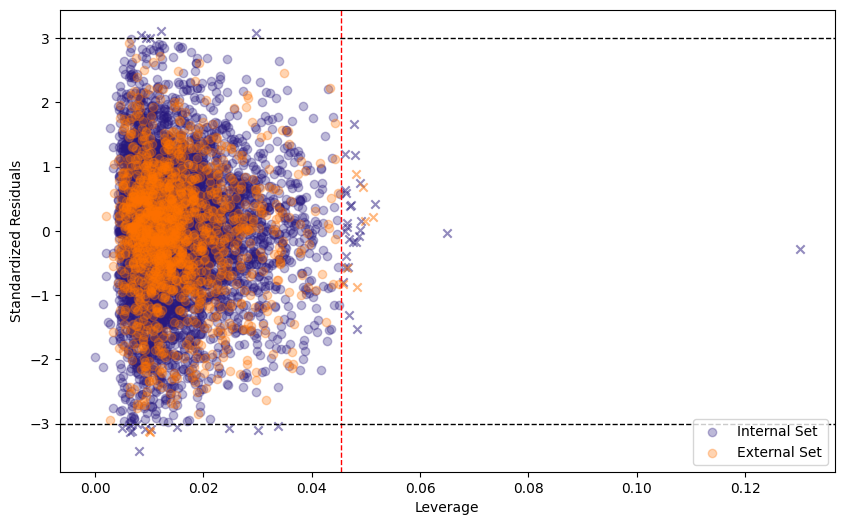

In [ ]:
# Plot
plt.figure(figsize=(10, 6))
plt.scatter(leverage_internal_filtered_3[~outliers_internal_filtered_3], std_residuals_internal_filtered_3[~outliers_internal_filtered_3], alpha=0.3, color='#27187eff', label='Internal Set')
plt.scatter(leverage_internal_filtered_3[outliers_internal_filtered_3], std_residuals_internal_filtered_3[outliers_internal_filtered_3], color='#27187eff', marker="x", alpha=0.5)
plt.scatter(leverage_external_filtered_3[~outliers_external_filtered_3], std_residuals_external_filtered_3[~outliers_external_filtered_3], alpha=0.3, color='#FF7200', label='External Set')
plt.scatter(leverage_external_filtered_3[outliers_external_filtered_3], std_residuals_external_filtered_3[outliers_external_filtered_3], color='#FF7200', marker="x", alpha=0.5)

plt.axvline(x=leverage_threshold_filtered_3, color='red', linestyle='--', linewidth=1)
plt.axhline(y=std_dev, color='black', linestyle='--', linewidth=1)
plt.axhline(y=-std_dev, color='black', linestyle='--', linewidth=1)

plt.xlabel('Leverage')
plt.ylabel('Standardized Residuals')
plt.legend(loc='lower right')

plt.savefig('KRC_AD4_williams_plot.png', dpi=300)
plt.show()


#AD MODEL 4

## removing outliers

In [ ]:
# Create a boolean mask for internal and external outliers
mask_internal_outliers_4 = np.isin(np.arange(len(X_internal_filtered_3)), compounds_internal_outliers_filtered_3)
mask_external_outliers_4 = np.isin(np.arange(len(X_external_filtered_3)), compounds_external_outliers_filtered_3)

# Remove internal outliers from training set
X_internal_filtered_4 = X_internal_filtered_3[~mask_internal_outliers_4]
Y_internal_filtered_4 = Y_internal_filtered_3[~mask_internal_outliers_4]

# Remove external outliers from test set
X_external_filtered_4 = X_external_filtered_3[~mask_external_outliers_4]
Y_external_filtered_4 = Y_external_filtered_3[~mask_external_outliers_4]


##AD Defining Functions


In [ ]:
def AD4_Y_scrambling(X_internal, X_external, Y_internal, Y_external, df_name):
    predictionOnExternal_scrambledtrain = []
    predictionOnInternal_scrambledtrain = []

    for randomseedcounter in range(1, 11):  # 10 iterations
        y_train_scrambled = deepcopy(Y_internal.values)
        X_train_scrambled = deepcopy(X_internal.values)

        np.random.shuffle(y_train_scrambled)
        np.random.shuffle(X_train_scrambled)

        RF_scrambled = RandomForestRegressor(max_depth=60,
                                             max_features='sqrt',
                                             min_samples_split=4,
                                             n_estimators=940,
                                             random_state=42,
                                             n_jobs=-1,
                                             verbose=1)  ## TO EDIT BASED FROM BEST HP

        RF_scrambled.fit(X_internal, y_train_scrambled)

        # Prediction on the external set
        y_predict_scrambled = RF_scrambled.predict(X_external)
        r2_test_scrambled = (RF_scrambled.score(X_external, Y_external))**2
        predictionOnExternal_scrambledtrain.append(r2_test_scrambled)

        # Prediction on the internal set
        y_predict_scrambled_predictTrain = RF_scrambled.predict(X_internal)
        r2_train_scrambled = (RF_scrambled.score(X_internal, Y_internal))**2
        predictionOnInternal_scrambledtrain.append(r2_train_scrambled)

    result = pd.DataFrame({
        'R2_scrambled': predictionOnInternal_scrambledtrain,
        'Q2_scrambled': predictionOnExternal_scrambledtrain
    })

    result.to_csv(f'AD4_Y_scrambling_results_{df_name}.csv', index=False)

    return predictionOnExternal_scrambledtrain, predictionOnInternal_scrambledtrain

In [ ]:
def AD4_plot_model(df_name, X_internal, X_external, Y_internal, Y_external, rf, hx):
    # Prepare plot
    fig_size = plt.rcParams["figure.figsize"]
    fig_size[0] = 15
    fig_size[1] = 5

    # Train Set
    plt.subplot(1, 3, 1)
    m = rf.fit(X_internal, Y_internal)
    x_train = np.array(Y_internal)
    y_train = m.predict(X_internal).flatten()
    sns.regplot(x=x_train, y=y_train, scatter_kws={'color': '#27187eff', 'alpha': 0.3}, line_kws={'color': 'gray'}, ci=None)
    plt.xlabel("Experimental $pIC_{50}$ values", fontsize=10)
    plt.ylabel("Predicted $pIC_{50}$ values", fontsize=10)
    plt.title("Train Set")

    # CV Set
    plt.subplot(1, 3, 2)
    cv = cross_val_predict(rf, X_internal, Y_internal, cv=10, n_jobs=-1)
    x_test = np.array(Y_internal)
    y_test = cv
    sns.regplot(x=x_test, y=y_test, scatter_kws={'color': '#FF7200', 'alpha': 0.3}, line_kws={'color': 'gray'}, ci=None)
    plt.xlabel("Experimental $pIC_{50}$ values", fontsize=10)
    plt.ylabel("Predicted $pIC_{50}$ values", fontsize=10)
    plt.title("CV Set")

    # External Set
    plt.subplot(1, 3, 3)
    x_test = np.array(Y_external)
    y_test = m.predict(X_external).flatten()
    sns.regplot(x=x_test, y=y_test, scatter_kws={'color': '#2b9348', 'alpha': 0.3}, line_kws={'color': 'gray'}, ci=None)
    plt.xlabel("Experimental $pIC_{50}$ values", fontsize=10)
    plt.ylabel("Predicted $pIC_{50}$ values", fontsize=10)
    plt.title("External Set")

    plt.tight_layout()
    plt.savefig(f'AD4_{df_name}_compare.png', dpi=300)

In [ ]:
def AD4_build_model(X_internal, Y_internal, X_external, Y_external, config=None):
    if config is None:
        config = {
            'hx': X_internal.columns.tolist(),
            'df_name': 'KlekotaRothCount',
            'rf_params': {
                'max_depth': 60,
                'max_features': 'sqrt',
                'min_samples_split': 4,
                'n_estimators': 940,
                'random_state': 42,
                'n_jobs': -1,
                'verbose': 1
            }
        }

    models = []
    all_metrics_results = {
        'MAE_train': [],
        'R2_train': [],
        'RMSE_train': [],
        'MAE_CV': [],
        'Q2_CV': [],
        'RMSE_CV': [],
        'MAE_External': [],
        'Q2_External': [],
        'RMSE_External': []
    }

    # Extracting parameters from the config dictionary
    hx = config['hx']
    df_name = config['df_name']
    rf_params = config['rf_params']

    feature_importances_results = {
        'importances_dict': defaultdict(list)
    }

    y_scrambling_results_external = []
    y_scrambling_results_internal = []

    # Internal set
    rf = RandomForestRegressor(**rf_params)
    rf.fit(X_internal, Y_internal)
    prediction_internal = rf.predict(X_internal)

    # Cross-validation
    cv = cross_val_predict(rf, X_internal, Y_internal, cv=10, n_jobs=-1)

    # External set
    prediction_external = rf.predict(X_external)

    # Save the trained model using joblib
    model_filename = f'AD4_trained_model_{df_name}.joblib'
    joblib.dump(rf, model_filename)

    # Append the model to the list
    models.append(model_filename)

    # Store results for the single split
    all_metrics_results['MAE_train'].append(mean_absolute_error(Y_internal, prediction_internal))
    all_metrics_results['R2_train'].append(r2_score(Y_internal, prediction_internal))
    all_metrics_results['RMSE_train'].append(np.sqrt(mean_squared_error(Y_internal, prediction_internal)))
    all_metrics_results['MAE_CV'].append(mean_absolute_error(Y_internal, cv))
    all_metrics_results['Q2_CV'].append(r2_score(Y_internal, cv))
    all_metrics_results['RMSE_CV'].append(np.sqrt(mean_squared_error(Y_internal, cv)))
    all_metrics_results['MAE_External'].append(mean_absolute_error(Y_external, prediction_external))
    all_metrics_results['Q2_External'].append(r2_score(Y_external, prediction_external))
    all_metrics_results['RMSE_External'].append(np.sqrt(mean_squared_error(Y_external, prediction_external)))

    # Feature Importance
    feature_importance = rf.feature_importances_
    importances = list(zip(hx, feature_importance))
    importances = sorted(importances, key=lambda x: x[1], reverse=True)

    # Feature importance Visualization
    fig_size = plt.rcParams["figure.figsize"]
    fig_size[0] = 5
    fig_size[1] = 10

    barlist = plt.barh(range(20), [x[1] for x in importances[:20]],
                      color="#27187eff", xerr=[x[1] for x in importances[:20]],
                      align="center", error_kw=dict(ecolor='gray', lw=2, capsize=5, capthick=2))

    plt.yticks(range(20), [x[0] for x in importances[:20]])
    plt.ylim([-1, 20])

    plt.xlabel(r"$\bf{Gini}$" + " " + r"$\bf{index}$", fontsize=12)
    ax = plt.gca()
    ax.invert_yaxis()
    plt.tight_layout(pad=2.0, w_pad=0.7, h_pad=2.0)

    # Save the feature importance plot
    plt.savefig(f'AD4_{df_name}_Feature_importances.png', dpi=300)
    plt.close()

    # Store feature importances
    for i, fx in enumerate(hx):
        feature_importances_results['importances_dict'][fx].append(feature_importance[i])

    # Y Scrambling
    y_scrambling_results_internal_split, y_scrambling_results_external_split = AD4_Y_scrambling(X_internal, X_external, Y_internal, Y_external, df_name)

    y_scrambling_results_external.append(y_scrambling_results_external_split)
    y_scrambling_results_internal.append(y_scrambling_results_internal_split)

    # Plotting
    AD4_plot_model(df_name, X_internal, X_external, Y_internal, Y_external, rf, hx)

    return (
        all_metrics_results,
        models,
        feature_importances_results,
        y_scrambling_results_external,
        y_scrambling_results_internal,
        rf)


##Running all the defined functions

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 196 tasks      | elapsed:    1.5s
[Parallel(n_jobs=-1)]: Done 446 tasks      | elapsed:    3.3s
[Parallel(n_jobs=-1)]: Done 796 tasks      | elapsed:    7.6s
[Parallel(n_jobs=-1)]: Done 940 out of 940 | elapsed:    8.7s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done 196 tasks      | elapsed:    0.2s
[Parallel(n_jobs=2)]: Done 446 tasks      | elapsed:    0.4s
[Parallel(n_jobs=2)]: Done 796 tasks      | elapsed:    0.8s
[Parallel(n_jobs=2)]: Done 940 out of 940 | elapsed:    0.9s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done 196 tasks      | elapsed:    0.1s
[Par

Built model for a single DataFrame.


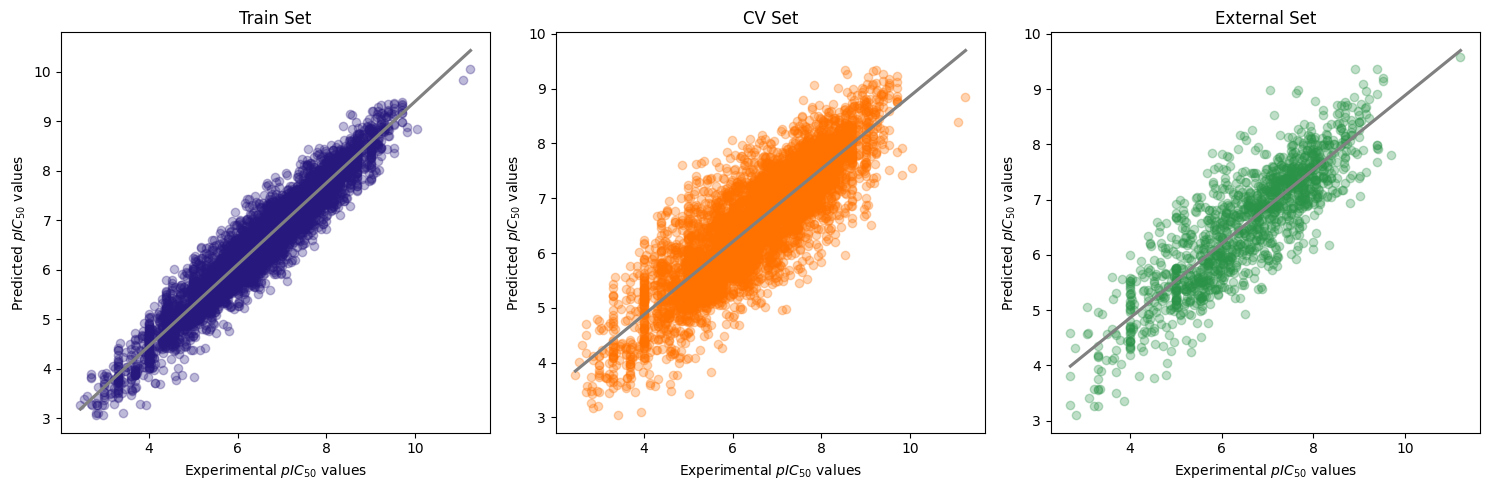

In [ ]:
# Build the model using filtered datasets
all_metrics_results, models, feature_importances_results, y_scrambling_results_external, y_scrambling_results_internal, rf = AD4_build_model(
    X_internal_filtered_4,
    Y_internal_filtered_4,
    X_external_filtered_4,
    Y_external_filtered_4
)

# CSV for all metrics
pd.DataFrame(all_metrics_results).to_csv('/content/gdrive/Shareddrives/Thesis (PS4)/[01] Colab/[03] MV/KRC_AD4_model_results_metrics.csv', index=False)

# CSV for feature importances
pd.DataFrame(feature_importances_results['importances_dict']).to_csv('/content/gdrive/Shareddrives/Thesis (PS4)/[01] Colab/[03] MV/KRC_AD4_model_results_importances.csv', index=False)

print("Built model for a single DataFrame.")

##Applicability domain 5


In [ ]:
# Fit and predict using filtered datasets
rf_params = {
    'max_depth': 60,
    'max_features': 'sqrt',
    'min_samples_split': 4,
    'n_estimators': 940,
    'random_state': 42,
    'n_jobs': -1,
    'verbose': 1
}


rf_internal_AD4 = RandomForestRegressor(**rf_params)
rf_internal_AD4.fit(X_internal_filtered_4, Y_internal_filtered_4)

Y_internal_pred_filtered_4 = rf_internal_AD4.predict(X_internal_filtered_4)
Y_external_pred_filtered_4 = rf_internal_AD4.predict(X_external_filtered_4)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 196 tasks      | elapsed:    1.5s
[Parallel(n_jobs=-1)]: Done 446 tasks      | elapsed:    3.3s
[Parallel(n_jobs=-1)]: Done 796 tasks      | elapsed:    6.9s
[Parallel(n_jobs=-1)]: Done 940 out of 940 | elapsed:    9.4s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done 196 tasks      | elapsed:    0.2s
[Parallel(n_jobs=2)]: Done 446 tasks      | elapsed:    0.4s
[Parallel(n_jobs=2)]: Done 796 tasks      | elapsed:    0.7s
[Parallel(n_jobs=2)]: Done 940 out of 940 | elapsed:    0.9s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done 196 tasks      | elapsed:    0.1s
[Par

In [ ]:
# Calculate Mean Squared Error for internal and external datasets
mse_internal_filtered_4 = mean_squared_error(Y_internal_filtered_4, Y_internal_pred_filtered_4)
mse_external_filtered_4 = mean_squared_error(Y_external_filtered_4, Y_external_pred_filtered_4)

In [ ]:
# Calculate Standardized Residuals
std_residuals_internal_filtered_4 = (Y_internal_filtered_4 - Y_internal_pred_filtered_4) / np.sqrt(mse_internal_filtered_4)
std_residuals_external_filtered_4 = (Y_external_filtered_4 - Y_external_pred_filtered_4) / np.sqrt(mse_external_filtered_4)

std_residual_threshold = 3

In [ ]:
# Calculate Leverage (H) values using pseudo-inverse
hat_matrix_internal_filtered_4 = np.dot(X_internal_filtered_4, np.dot(np.linalg.pinv(np.dot(X_internal_filtered_4.T, X_internal_filtered_4)), X_internal_filtered_4.T))
hat_matrix_external_filtered_4 = np.dot(X_external_filtered_4, np.dot(np.linalg.pinv(np.dot(X_internal_filtered_4.T, X_internal_filtered_4)), X_external_filtered_4.T))

leverage_internal_filtered_4 = np.diag(hat_matrix_internal_filtered_4)
leverage_external_filtered_4 = np.diag(hat_matrix_external_filtered_4)


In [ ]:
# Leverage threshold calculation
k = X_internal_filtered_4.shape[1] - 1
n = X_internal_filtered_4.shape[0]
leverage_threshold_filtered_4 = 3 * (k + 1) / n
leverage_threshold_filtered_4

0.04570184983677911

0.04570184983677911

In [ ]:
# Identify outliers based on leverage and standardized residuals
outliers_leverage_internal_filtered_4 = leverage_internal_filtered_4 > leverage_threshold_filtered_4
outliers_std_residual_internal_filtered_4 = np.abs(std_residuals_internal_filtered_4) > std_residual_threshold

outliers_leverage_external_filtered_4 = leverage_external_filtered_4 > leverage_threshold_filtered_4
outliers_std_residual_external_filtered_4 = np.abs(std_residuals_external_filtered_4) > std_residual_threshold

# Combine the conditions to identify outliers
outliers_internal_filtered_4 = outliers_leverage_internal_filtered_4 | outliers_std_residual_internal_filtered_4
outliers_external_filtered_4 = outliers_leverage_external_filtered_4 | outliers_std_residual_external_filtered_4

# Compute the number and percentage of outliers
num_outliers_internal_filtered_4 = np.sum(outliers_internal_filtered_4)
num_outliers_external_filtered_4 = np.sum(outliers_external_filtered_4)

percentage_outliers_internal_filtered_4 = (num_outliers_internal_filtered_4 / len(std_residuals_internal_filtered_4)) * 100
percentage_outliers_external_filtered_4 = (num_outliers_external_filtered_4 / len(std_residuals_external_filtered_4)) * 100

# Print the number and percentage of outliers
print(f"Number of Internal Outliers: {num_outliers_internal_filtered_4}, Percentage: {percentage_outliers_internal_filtered_4:.2f}%")
print(f"Number of External Outliers: {num_outliers_external_filtered_4}, Percentage: {percentage_outliers_external_filtered_4:.2f}%")

Number of Internal Outliers: 26, Percentage: 0.47%
Number of External Outliers: 5, Percentage: 0.36%


Number of Internal Outliers: 26, Percentage: 0.47%
Number of External Outliers: 5, Percentage: 0.36%

In [ ]:
# List compounds for outliers
compounds_internal_outliers_filtered_4 = np.where(outliers_internal_filtered_4)[0]
compounds_external_outliers_filtered_4 = np.where(outliers_external_filtered_4)[0]

# Print compounds and counts for internal and external outliers
print("\nCompounds for Internal Outliers:")
print(compounds_internal_outliers_filtered_4)
print("Count of Internal Outliers:", num_outliers_internal_filtered_4)

print("\nCompounds for External Outliers:")
print(compounds_external_outliers_filtered_4)
print("Count of External Outliers:", num_outliers_external_filtered_4)


percentage_outliers_internal_filtered_4 = (num_outliers_internal_filtered_4 / len(std_residuals_internal_filtered_4)) * 100
percentage_outliers_external_filtered_4 = (num_outliers_external_filtered_4 / len(std_residuals_external_filtered_4)) * 100

# Print the number and percentage of outliers
print(f"Percentage of Internal Outliers: {percentage_outliers_internal_filtered_4:.2f}%")
print(f"Percentage of External Outliers: {percentage_outliers_external_filtered_4:.2f}%")


Compounds for Internal Outliers:
[ 588  617  763  786 1276 1365 1455 1604 1741 1831 2094 2633 2642 2894
 2915 3187 3363 3838 4032 4155 4294 4370 4422 4453 5170 5472]
Count of Internal Outliers: 26

Compounds for External Outliers:
[  70   87  728 1290 1367]
Count of External Outliers: 5
Percentage of Internal Outliers: 0.47%
Percentage of External Outliers: 0.36%


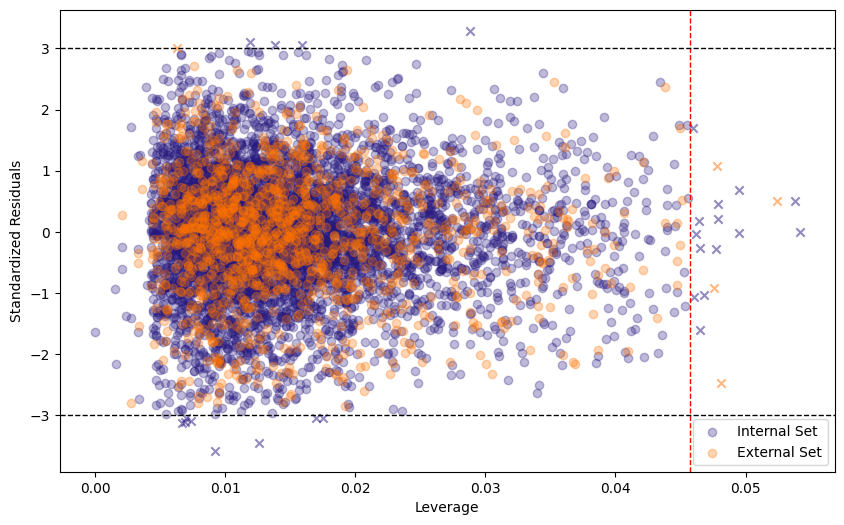

In [ ]:
# Plot
plt.figure(figsize=(10, 6))
plt.scatter(leverage_internal_filtered_4[~outliers_internal_filtered_4], std_residuals_internal_filtered_4[~outliers_internal_filtered_4], alpha=0.3, color='#27187eff', label='Internal Set')
plt.scatter(leverage_internal_filtered_4[outliers_internal_filtered_4], std_residuals_internal_filtered_4[outliers_internal_filtered_4], color='#27187eff', marker="x", alpha=0.5)
plt.scatter(leverage_external_filtered_4[~outliers_external_filtered_4], std_residuals_external_filtered_4[~outliers_external_filtered_4], alpha=0.3, color='#FF7200', label='External Set')
plt.scatter(leverage_external_filtered_4[outliers_external_filtered_4], std_residuals_external_filtered_4[outliers_external_filtered_4], color='#FF7200', marker="x", alpha=0.5)

plt.axvline(x=leverage_threshold_filtered_4, color='red', linestyle='--', linewidth=1)
plt.axhline(y=std_dev, color='black', linestyle='--', linewidth=1)
plt.axhline(y=-std_dev, color='black', linestyle='--', linewidth=1)

plt.xlabel('Leverage')
plt.ylabel('Standardized Residuals')
plt.legend(loc='lower right')

plt.savefig('KRC_AD5_williams_plot.png', dpi=300)
plt.show()


In [ ]:
compounds_internal_outliers_filtered_4 = pd.DataFrame(compounds_internal_outliers_filtered_4)
compounds_internal_outliers_filtered_4.to_csv('compounds_internal_outliers_filtered_4.csv', index=False)
compounds_external_outliers_filtered_4 = pd.DataFrame(compounds_external_outliers_filtered_4)
compounds_external_outliers_filtered_4.to_csv('compounds_external_outliers_filtered_4.csv', index=False)

#AD MODEL 5

## removing outliers

In [ ]:
# Create a boolean mask for internal and external outliers
mask_internal_outliers_5 = np.isin(np.arange(len(X_internal_filtered_4)), compounds_internal_outliers_filtered_4)
mask_external_outliers_5 = np.isin(np.arange(len(X_external_filtered_4)), compounds_external_outliers_filtered_4)

# Remove internal outliers from training set
X_internal_filtered_5 = X_internal_filtered_4[~mask_internal_outliers_5]
Y_internal_filtered_5 = Y_internal_filtered_4[~mask_internal_outliers_5]

# Remove external outliers from test set
X_external_filtered_5 = X_external_filtered_4[~mask_external_outliers_5]
Y_external_filtered_5 = Y_external_filtered_4[~mask_external_outliers_5]


##AD Defining Functions


In [ ]:
def AD5_Y_scrambling(X_internal, X_external, Y_internal, Y_external, df_name):
    predictionOnExternal_scrambledtrain = []
    predictionOnInternal_scrambledtrain = []

    for randomseedcounter in range(1, 11):  # 10 iterations
        y_train_scrambled = deepcopy(Y_internal.values)
        X_train_scrambled = deepcopy(X_internal.values)

        np.random.shuffle(y_train_scrambled)
        np.random.shuffle(X_train_scrambled)

        RF_scrambled = RandomForestRegressor(max_depth=60,
                                             max_features='sqrt',
                                             min_samples_split=4,
                                             n_estimators=940,
                                             random_state=42,
                                             n_jobs=-1,
                                             verbose=1)  ## TO EDIT BASED FROM BEST HP

        RF_scrambled.fit(X_internal, y_train_scrambled)

        # Prediction on the external set
        y_predict_scrambled = RF_scrambled.predict(X_external)
        r2_test_scrambled = (RF_scrambled.score(X_external, Y_external))**2
        predictionOnExternal_scrambledtrain.append(r2_test_scrambled)

        # Prediction on the internal set
        y_predict_scrambled_predictTrain = RF_scrambled.predict(X_internal)
        r2_train_scrambled = (RF_scrambled.score(X_internal, Y_internal))**2
        predictionOnInternal_scrambledtrain.append(r2_train_scrambled)

    result = pd.DataFrame({
        'R2_scrambled': predictionOnInternal_scrambledtrain,
        'Q2_scrambled': predictionOnExternal_scrambledtrain
    })

    result.to_csv(f'AD5_Y_scrambling_results_{df_name}.csv', index=False)

    return predictionOnExternal_scrambledtrain, predictionOnInternal_scrambledtrain

In [ ]:
def AD5_plot_model(df_name, X_internal, X_external, Y_internal, Y_external, rf, hx):
    # Prepare plot
    fig_size = plt.rcParams["figure.figsize"]
    fig_size[0] = 15
    fig_size[1] = 5

    # Train Set
    plt.subplot(1, 3, 1)
    m = rf.fit(X_internal, Y_internal)
    x_train = np.array(Y_internal)
    y_train = m.predict(X_internal).flatten()
    sns.regplot(x=x_train, y=y_train, scatter_kws={'color': '#27187eff', 'alpha': 0.3}, line_kws={'color': 'gray'}, ci=None)
    plt.xlabel("Experimental $pIC_{50}$ values", fontsize=10)
    plt.ylabel("Predicted $pIC_{50}$ values", fontsize=10)
    plt.title("Train Set")

    # CV Set
    plt.subplot(1, 3, 2)
    cv = cross_val_predict(rf, X_internal, Y_internal, cv=10, n_jobs=-1)
    x_test = np.array(Y_internal)
    y_test = cv
    sns.regplot(x=x_test, y=y_test, scatter_kws={'color': '#FF7200', 'alpha': 0.3}, line_kws={'color': 'gray'}, ci=None)
    plt.xlabel("Experimental $pIC_{50}$ values", fontsize=10)
    plt.ylabel("Predicted $pIC_{50}$ values", fontsize=10)
    plt.title("CV Set")

    # External Set
    plt.subplot(1, 3, 3)
    x_test = np.array(Y_external)
    y_test = m.predict(X_external).flatten()
    sns.regplot(x=x_test, y=y_test, scatter_kws={'color': '#2b9348', 'alpha': 0.3}, line_kws={'color': 'gray'}, ci=None)
    plt.xlabel("Experimental $pIC_{50}$ values", fontsize=10)
    plt.ylabel("Predicted $pIC_{50}$ values", fontsize=10)
    plt.title("External Set")

    plt.tight_layout()
    plt.savefig(f'AD5_{df_name}_compare.png', dpi=300)

In [ ]:
def AD5_build_model(X_internal, Y_internal, X_external, Y_external, config=None):
    if config is None:
        config = {
            'hx': X_internal.columns.tolist(),
            'df_name': 'KlekotaRothCount',
            'rf_params': {
                'max_depth': 60,
                'max_features': 'sqrt',
                'min_samples_split': 4,
                'n_estimators': 940,
                'random_state': 42,
                'n_jobs': -1,
                'verbose': 1
            }
        }

    models = []
    all_metrics_results = {
        'MAE_train': [],
        'R2_train': [],
        'RMSE_train': [],
        'MAE_CV': [],
        'Q2_CV': [],
        'RMSE_CV': [],
        'MAE_External': [],
        'Q2_External': [],
        'RMSE_External': []
    }

    # Extracting parameters from the config dictionary
    hx = config['hx']
    df_name = config['df_name']
    rf_params = config['rf_params']

    feature_importances_results = {
        'importances_dict': defaultdict(list)
    }

    y_scrambling_results_external = []
    y_scrambling_results_internal = []

    # Internal set
    rf = RandomForestRegressor(**rf_params)
    rf.fit(X_internal, Y_internal)
    prediction_internal = rf.predict(X_internal)

    # Cross-validation
    cv = cross_val_predict(rf, X_internal, Y_internal, cv=10, n_jobs=-1)

    # External set
    prediction_external = rf.predict(X_external)

    # Save the trained model using joblib
    model_filename = f'AD5_trained_model_{df_name}.joblib'
    joblib.dump(rf, model_filename)

    # Append the model to the list
    models.append(model_filename)

    # Store results for the single split
    all_metrics_results['MAE_train'].append(mean_absolute_error(Y_internal, prediction_internal))
    all_metrics_results['R2_train'].append(r2_score(Y_internal, prediction_internal))
    all_metrics_results['RMSE_train'].append(np.sqrt(mean_squared_error(Y_internal, prediction_internal)))
    all_metrics_results['MAE_CV'].append(mean_absolute_error(Y_internal, cv))
    all_metrics_results['Q2_CV'].append(r2_score(Y_internal, cv))
    all_metrics_results['RMSE_CV'].append(np.sqrt(mean_squared_error(Y_internal, cv)))
    all_metrics_results['MAE_External'].append(mean_absolute_error(Y_external, prediction_external))
    all_metrics_results['Q2_External'].append(r2_score(Y_external, prediction_external))
    all_metrics_results['RMSE_External'].append(np.sqrt(mean_squared_error(Y_external, prediction_external)))

    # Feature Importance
    feature_importance = rf.feature_importances_
    importances = list(zip(hx, feature_importance))
    importances = sorted(importances, key=lambda x: x[1], reverse=True)

    # Feature importance Visualization
    fig_size = plt.rcParams["figure.figsize"]
    fig_size[0] = 5
    fig_size[1] = 10

    barlist = plt.barh(range(20), [x[1] for x in importances[:20]],
                      color="#27187eff", xerr=[x[1] for x in importances[:20]],
                      align="center", error_kw=dict(ecolor='gray', lw=2, capsize=5, capthick=2))

    plt.yticks(range(20), [x[0] for x in importances[:20]])
    plt.ylim([-1, 20])

    plt.xlabel(r"$\bf{Gini}$" + " " + r"$\bf{index}$", fontsize=12)
    ax = plt.gca()
    ax.invert_yaxis()
    plt.tight_layout(pad=2.0, w_pad=0.7, h_pad=2.0)

    # Save the feature importance plot
    plt.savefig(f'AD5_{df_name}_Feature_importances.png', dpi=300)
    plt.close()

    # Store feature importances
    for i, fx in enumerate(hx):
        feature_importances_results['importances_dict'][fx].append(feature_importance[i])

    # Y Scrambling
    y_scrambling_results_internal_split, y_scrambling_results_external_split = AD5_Y_scrambling(X_internal, X_external, Y_internal, Y_external, df_name)

    y_scrambling_results_external.append(y_scrambling_results_external_split)
    y_scrambling_results_internal.append(y_scrambling_results_internal_split)

    # Plotting
    AD5_plot_model(df_name, X_internal, X_external, Y_internal, Y_external, rf, hx)

    return (
        all_metrics_results,
        models,
        feature_importances_results,
        y_scrambling_results_external,
        y_scrambling_results_internal,
        rf)


##Running all the defined functions

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 196 tasks      | elapsed:    1.4s
[Parallel(n_jobs=-1)]: Done 446 tasks      | elapsed:    3.2s
[Parallel(n_jobs=-1)]: Done 796 tasks      | elapsed:    5.8s
[Parallel(n_jobs=-1)]: Done 940 out of 940 | elapsed:    6.8s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done 196 tasks      | elapsed:    0.2s
[Parallel(n_jobs=2)]: Done 446 tasks      | elapsed:    0.4s
[Parallel(n_jobs=2)]: Done 796 tasks      | elapsed:    0.8s
[Parallel(n_jobs=2)]: Done 940 out of 940 | elapsed:    0.9s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done 196 tasks      | elapsed:    0.1s
[Par

Built model for a single DataFrame.


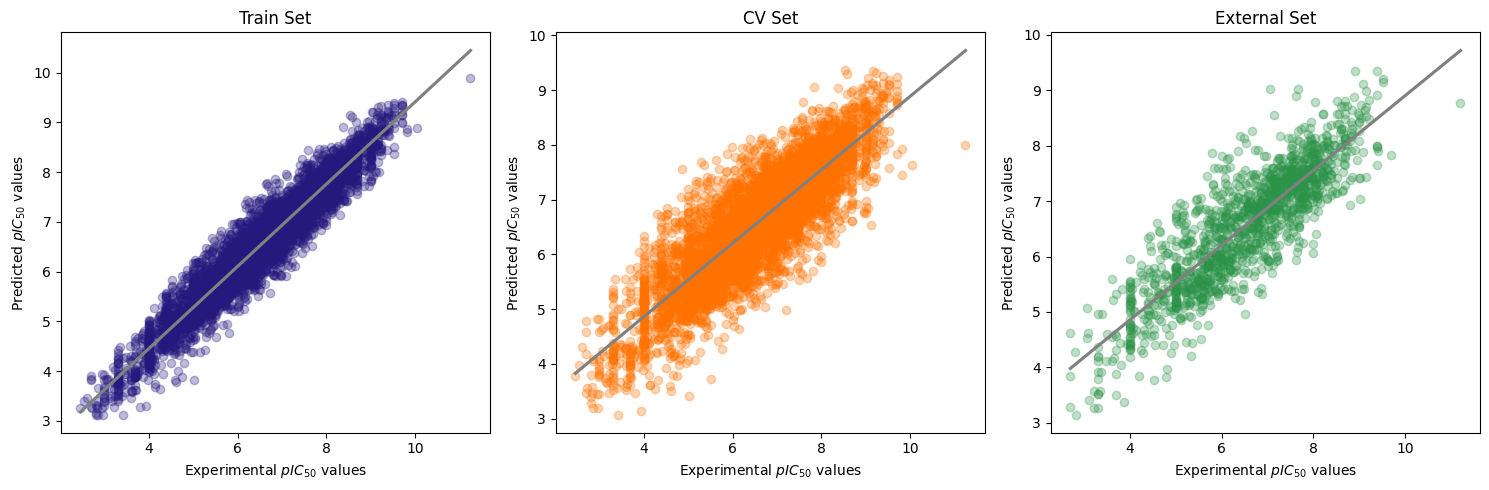

In [ ]:
# Build the model using filtered datasets
all_metrics_results, models, feature_importances_results, y_scrambling_results_external, y_scrambling_results_internal, rf = AD5_build_model(
    X_internal_filtered_5,
    Y_internal_filtered_5,
    X_external_filtered_5,
    Y_external_filtered_5
)

# CSV for all metrics
pd.DataFrame(all_metrics_results).to_csv('/content/gdrive/Shareddrives/Thesis (PS4)/[01] Colab/[03] MV/KRC_AD5_model_results_metrics.csv', index=False)

# CSV for feature importances
pd.DataFrame(feature_importances_results['importances_dict']).to_csv('/content/gdrive/Shareddrives/Thesis (PS4)/[01] Colab/[03] MV/KRC_AD5_model_results_importances.csv', index=False)

print("Built model for a single DataFrame.")

##Applicability domain 6


In [ ]:
# Fit and predict using filtered datasets
rf_params = {
    'max_depth': 60,
    'max_features': 'sqrt',
    'min_samples_split': 4,
    'n_estimators': 940,
    'random_state': 42,
    'n_jobs': -1,
    'verbose': 1
}


rf_internal_AD5 = RandomForestRegressor(**rf_params)
rf_internal_AD5.fit(X_internal_filtered_5, Y_internal_filtered_5)

Y_internal_pred_filtered_5 = rf_internal_AD5.predict(X_internal_filtered_5)
Y_external_pred_filtered_5 = rf_internal_AD5.predict(X_external_filtered_5)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 196 tasks      | elapsed:    1.9s
[Parallel(n_jobs=-1)]: Done 446 tasks      | elapsed:    5.1s
[Parallel(n_jobs=-1)]: Done 796 tasks      | elapsed:    7.7s
[Parallel(n_jobs=-1)]: Done 940 out of 940 | elapsed:    8.7s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done 196 tasks      | elapsed:    0.2s
[Parallel(n_jobs=2)]: Done 446 tasks      | elapsed:    0.4s
[Parallel(n_jobs=2)]: Done 796 tasks      | elapsed:    0.7s
[Parallel(n_jobs=2)]: Done 940 out of 940 | elapsed:    0.9s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done 196 tasks      | elapsed:    0.1s
[Par

In [ ]:
# Calculate Mean Squared Error for internal and external datasets
mse_internal_filtered_5 = mean_squared_error(Y_internal_filtered_5, Y_internal_pred_filtered_5)
mse_external_filtered_5 = mean_squared_error(Y_external_filtered_5, Y_external_pred_filtered_5)

In [ ]:
# Calculate Standardized Residuals
std_residuals_internal_filtered_5 = (Y_internal_filtered_5 - Y_internal_pred_filtered_5) / np.sqrt(mse_internal_filtered_5)
std_residuals_external_filtered_5 = (Y_external_filtered_5 - Y_external_pred_filtered_5) / np.sqrt(mse_external_filtered_5)

std_residual_threshold = 3

In [ ]:
# Calculate Leverage (H) values using pseudo-inverse
hat_matrix_internal_filtered_5 = np.dot(X_internal_filtered_5, np.dot(np.linalg.pinv(np.dot(X_internal_filtered_5.T, X_internal_filtered_5)), X_internal_filtered_5.T))
hat_matrix_external_filtered_5 = np.dot(X_external_filtered_5, np.dot(np.linalg.pinv(np.dot(X_internal_filtered_5.T, X_internal_filtered_5)), X_external_filtered_5.T))

leverage_internal_filtered_5 = np.diag(hat_matrix_internal_filtered_5)
leverage_external_filtered_5 = np.diag(hat_matrix_external_filtered_5)


In [ ]:
# Leverage threshold calculation
k = X_internal_filtered_5.shape[1] - 1
n = X_internal_filtered_5.shape[0]
leverage_threshold_filtered_5 = 3 * (k + 1) / n
leverage_threshold_filtered_5

0.04591836734693878

0.04591836734693878


In [ ]:
# Identify outliers based on leverage and standardized residuals
outliers_leverage_internal_filtered_5 = leverage_internal_filtered_5 > leverage_threshold_filtered_5
outliers_std_residual_internal_filtered_5 = np.abs(std_residuals_internal_filtered_5) > std_residual_threshold

outliers_leverage_external_filtered_5 = leverage_external_filtered_5 > leverage_threshold_filtered_5
outliers_std_residual_external_filtered_5 = np.abs(std_residuals_external_filtered_5) > std_residual_threshold

# Combine the conditions to identify outliers
outliers_internal_filtered_5 = outliers_leverage_internal_filtered_5 | outliers_std_residual_internal_filtered_5
outliers_external_filtered_5 = outliers_leverage_external_filtered_5 | outliers_std_residual_external_filtered_5

# Compute the number and percentage of outliers
num_outliers_internal_filtered_5 = np.sum(outliers_internal_filtered_5)
num_outliers_external_filtered_5 = np.sum(outliers_external_filtered_5)

percentage_outliers_internal_filtered_5 = (num_outliers_internal_filtered_5 / len(std_residuals_internal_filtered_5)) * 100
percentage_outliers_external_filtered_5 = (num_outliers_external_filtered_5 / len(std_residuals_external_filtered_5)) * 100

# Print the number and percentage of outliers
print(f"Number of Internal Outliers: {num_outliers_internal_filtered_5}, Percentage: {percentage_outliers_internal_filtered_5:.2f}%")
print(f"Number of External Outliers: {num_outliers_external_filtered_5}, Percentage: {percentage_outliers_external_filtered_5:.2f}%")

Number of Internal Outliers: 17, Percentage: 0.31%
Number of External Outliers: 5, Percentage: 0.36%


Number of Internal Outliers: 17, Percentage: 0.31%
Number of External Outliers: 5, Percentage: 0.36%

In [ ]:
# List compounds for outliers
compounds_internal_outliers_filtered_5 = np.where(outliers_internal_filtered_5)[0]
compounds_external_outliers_filtered_5 = np.where(outliers_external_filtered_5)[0]

# Print compounds and counts for internal and external outliers
print("\nCompounds for Internal Outliers:")
print(compounds_internal_outliers_filtered_5)
print("Count of Internal Outliers:", num_outliers_internal_filtered_5)

print("\nCompounds for External Outliers:")
print(compounds_external_outliers_filtered_5)
print("Count of External Outliers:", num_outliers_external_filtered_5)


percentage_outliers_internal_filtered_5 = (num_outliers_internal_filtered_5 / len(std_residuals_internal_filtered_5)) * 100
percentage_outliers_external_filtered_5 = (num_outliers_external_filtered_5 / len(std_residuals_external_filtered_5)) * 100

# Print the number and percentage of outliers
print(f"Percentage of Internal Outliers: {percentage_outliers_internal_filtered_5:.2f}%")
print(f"Percentage of External Outliers: {percentage_outliers_external_filtered_5:.2f}%")


Compounds for Internal Outliers:
[ 567 1041 1050 1278 1658 2455 2634 2957 2986 3007 3128 3202 3757 4045
 4132 5147 5341]
Count of Internal Outliers: 17

Compounds for External Outliers:
[ 410  841  928  998 1264]
Count of External Outliers: 5
Percentage of Internal Outliers: 0.31%
Percentage of External Outliers: 0.36%


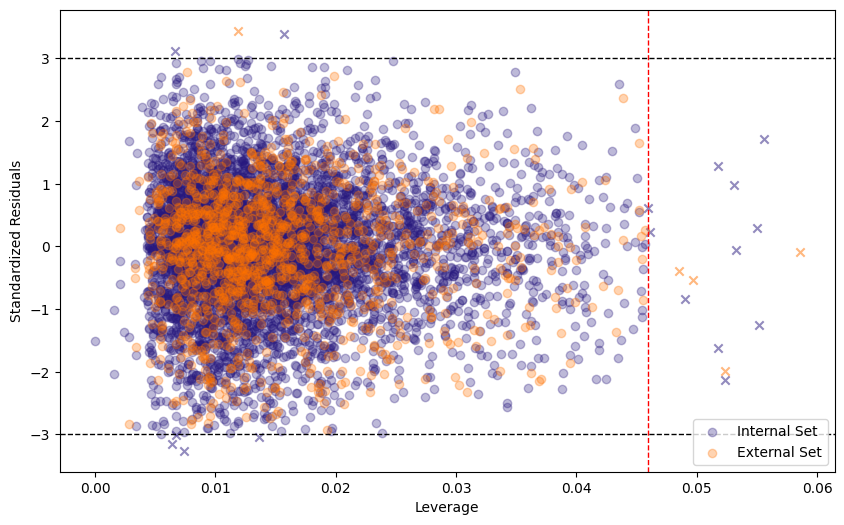

In [ ]:
# Plot
plt.figure(figsize=(10, 6))
plt.scatter(leverage_internal_filtered_5[~outliers_internal_filtered_5], std_residuals_internal_filtered_5[~outliers_internal_filtered_5], alpha=0.3, color='#27187eff', label='Internal Set')
plt.scatter(leverage_internal_filtered_5[outliers_internal_filtered_5], std_residuals_internal_filtered_5[outliers_internal_filtered_5], color='#27187eff', marker="x", alpha=0.5)
plt.scatter(leverage_external_filtered_5[~outliers_external_filtered_5], std_residuals_external_filtered_5[~outliers_external_filtered_5], alpha=0.3, color='#FF7200', label='External Set')
plt.scatter(leverage_external_filtered_5[outliers_external_filtered_5], std_residuals_external_filtered_5[outliers_external_filtered_5], color='#FF7200', marker="x", alpha=0.5)

plt.axvline(x=leverage_threshold_filtered_5, color='red', linestyle='--', linewidth=1)
plt.axhline(y=std_dev, color='black', linestyle='--', linewidth=1)
plt.axhline(y=-std_dev, color='black', linestyle='--', linewidth=1)

plt.xlabel('Leverage')
plt.ylabel('Standardized Residuals')
plt.legend(loc='lower right')

plt.savefig('KRC_AD6_williams_plot.png', dpi=300)
plt.show()


In [ ]:
compounds_internal_outliers_filtered_5 = pd.DataFrame(compounds_internal_outliers_filtered_5)
compounds_internal_outliers_filtered_5.to_csv('compounds_internal_outliers_filtered_5.csv', index=False)
compounds_external_outliers_filtered_5 = pd.DataFrame(compounds_external_outliers_filtered_5)
compounds_external_outliers_filtered_5.to_csv('compounds_external_outliers_filtered_5.csv', index=False)

#AD MODEL 6

## removing outliers

In [ ]:
Y_internal_filtered_5=pd.read_csv('Y_internal_filtered_5.csv')
Y_external_filtered_5=pd.read_csv('Y_external_filtered_5.csv')
X_internal_filtered_5=pd.read_csv('X_internal_filtered_5.csv')
X_external_filtered_5=pd.read_csv('X_external_filtered_5.csv')

FileNotFoundError: [Errno 2] No such file or directory: 'compounds_internal_outliers_filtered_5.csv'

In [ ]:
# Create a boolean mask for internal and external outliers
mask_internal_outliers_6 = np.isin(np.arange(len(X_internal_filtered_5)), compounds_internal_outliers_filtered_5)
mask_external_outliers_6 = np.isin(np.arange(len(X_external_filtered_5)), compounds_external_outliers_filtered_5)

# Remove internal outliers from training set
X_internal_filtered_6 = X_internal_filtered_5[~mask_internal_outliers_6]
Y_internal_filtered_6 = Y_internal_filtered_5[~mask_internal_outliers_6]

# Remove external outliers from test set
X_external_filtered_6 = X_external_filtered_5[~mask_external_outliers_6]
Y_external_filtered_6 = Y_external_filtered_5[~mask_external_outliers_6]


##AD Defining Functions


In [ ]:
def AD6_Y_scrambling(X_internal, X_external, Y_internal, Y_external, df_name):
    predictionOnExternal_scrambledtrain = []
    predictionOnInternal_scrambledtrain = []

    for randomseedcounter in range(1, 11):  # 10 iterations
        y_train_scrambled = deepcopy(Y_internal.values)
        X_train_scrambled = deepcopy(X_internal.values)

        np.random.shuffle(y_train_scrambled)
        np.random.shuffle(X_train_scrambled)

        RF_scrambled = RandomForestRegressor(max_depth=60,
                                             max_features='sqrt',
                                             min_samples_split=4,
                                             n_estimators=940,
                                             random_state=42,
                                             n_jobs=-1,
                                             verbose=1)  ## TO EDIT BASED FROM BEST HP

        RF_scrambled.fit(X_internal, y_train_scrambled)

        # Prediction on the external set
        y_predict_scrambled = RF_scrambled.predict(X_external)
        r2_test_scrambled = (RF_scrambled.score(X_external, Y_external))**2
        predictionOnExternal_scrambledtrain.append(r2_test_scrambled)

        # Prediction on the internal set
        y_predict_scrambled_predictTrain = RF_scrambled.predict(X_internal)
        r2_train_scrambled = (RF_scrambled.score(X_internal, Y_internal))**2
        predictionOnInternal_scrambledtrain.append(r2_train_scrambled)

    result = pd.DataFrame({
        'R2_scrambled': predictionOnInternal_scrambledtrain,
        'Q2_scrambled': predictionOnExternal_scrambledtrain
    })

    result.to_csv(f'AD6_Y_scrambling_results_{df_name}.csv', index=False)

    return predictionOnExternal_scrambledtrain, predictionOnInternal_scrambledtrain

In [ ]:
def AD6_plot_model(df_name, X_internal, X_external, Y_internal, Y_external, rf, hx):
    # Prepare plot
    fig_size = plt.rcParams["figure.figsize"]
    fig_size[0] = 15
    fig_size[1] = 5

    # Train Set
    plt.subplot(1, 3, 1)
    m = rf.fit(X_internal, Y_internal)
    x_train = np.array(Y_internal)
    y_train = m.predict(X_internal).flatten()
    sns.regplot(x=x_train, y=y_train, scatter_kws={'color': '#27187eff', 'alpha': 0.3}, line_kws={'color': 'gray'}, ci=None)
    plt.xlabel("Experimental $pIC_{50}$ values", fontsize=10)
    plt.ylabel("Predicted $pIC_{50}$ values", fontsize=10)
    plt.title("Train Set")

    # CV Set
    plt.subplot(1, 3, 2)
    cv = cross_val_predict(rf, X_internal, Y_internal, cv=10, n_jobs=-1)
    x_test = np.array(Y_internal)
    y_test = cv
    sns.regplot(x=x_test, y=y_test, scatter_kws={'color': '#FF7200', 'alpha': 0.3}, line_kws={'color': 'gray'}, ci=None)
    plt.xlabel("Experimental $pIC_{50}$ values", fontsize=10)
    plt.ylabel("Predicted $pIC_{50}$ values", fontsize=10)
    plt.title("CV Set")

    # External Set
    plt.subplot(1, 3, 3)
    x_test = np.array(Y_external)
    y_test = m.predict(X_external).flatten()
    sns.regplot(x=x_test, y=y_test, scatter_kws={'color': '#2b9348', 'alpha': 0.3}, line_kws={'color': 'gray'}, ci=None)
    plt.xlabel("Experimental $pIC_{50}$ values", fontsize=10)
    plt.ylabel("Predicted $pIC_{50}$ values", fontsize=10)
    plt.title("External Set")

    plt.tight_layout()
    plt.savefig(f'AD5_{df_name}_compare.png', dpi=300)

In [ ]:
def AD6_build_model(X_internal, Y_internal, X_external, Y_external, config=None):
    if config is None:
        config = {
            'hx': X_internal.columns.tolist(),
            'df_name': 'KlekotaRothCount',
            'rf_params': {
                'max_depth': 60,
                'max_features': 'sqrt',
                'min_samples_split': 4,
                'n_estimators': 940,
                'random_state': 42,
                'n_jobs': -1,
                'verbose': 1
            }
        }

    models = []
    all_metrics_results = {
        'MAE_train': [],
        'R2_train': [],
        'RMSE_train': [],
        'MAE_CV': [],
        'Q2_CV': [],
        'RMSE_CV': [],
        'MAE_External': [],
        'Q2_External': [],
        'RMSE_External': []
    }

    # Extracting parameters from the config dictionary
    hx = config['hx']
    df_name = config['df_name']
    rf_params = config['rf_params']

    feature_importances_results = {
        'importances_dict': defaultdict(list)
    }

    y_scrambling_results_external = []
    y_scrambling_results_internal = []

    # Internal set
    rf = RandomForestRegressor(**rf_params)
    rf.fit(X_internal, Y_internal)
    prediction_internal = rf.predict(X_internal)

    # Cross-validation
    cv = cross_val_predict(rf, X_internal, Y_internal, cv=10, n_jobs=-1)

    # External set
    prediction_external = rf.predict(X_external)

    # Save the trained model using joblib
    model_filename = f'AD6_trained_model_{df_name}.joblib'
    joblib.dump(rf, model_filename)

    # Append the model to the list
    models.append(model_filename)

    # Store results for the single split
    all_metrics_results['MAE_train'].append(mean_absolute_error(Y_internal, prediction_internal))
    all_metrics_results['R2_train'].append(r2_score(Y_internal, prediction_internal))
    all_metrics_results['RMSE_train'].append(np.sqrt(mean_squared_error(Y_internal, prediction_internal)))
    all_metrics_results['MAE_CV'].append(mean_absolute_error(Y_internal, cv))
    all_metrics_results['Q2_CV'].append(r2_score(Y_internal, cv))
    all_metrics_results['RMSE_CV'].append(np.sqrt(mean_squared_error(Y_internal, cv)))
    all_metrics_results['MAE_External'].append(mean_absolute_error(Y_external, prediction_external))
    all_metrics_results['Q2_External'].append(r2_score(Y_external, prediction_external))
    all_metrics_results['RMSE_External'].append(np.sqrt(mean_squared_error(Y_external, prediction_external)))

    # Feature Importance
    feature_importance = rf.feature_importances_
    importances = list(zip(hx, feature_importance))
    importances = sorted(importances, key=lambda x: x[1], reverse=True)

    # Feature importance Visualization
    fig_size = plt.rcParams["figure.figsize"]
    fig_size[0] = 5
    fig_size[1] = 10

    barlist = plt.barh(range(20), [x[1] for x in importances[:20]],
                      color="#27187eff", xerr=[x[1] for x in importances[:20]],
                      align="center", error_kw=dict(ecolor='gray', lw=2, capsize=5, capthick=2))

    plt.yticks(range(20), [x[0] for x in importances[:20]])
    plt.ylim([-1, 20])

    plt.xlabel(r"$\bf{Gini}$" + " " + r"$\bf{index}$", fontsize=12)
    ax = plt.gca()
    ax.invert_yaxis()
    plt.tight_layout(pad=2.0, w_pad=0.7, h_pad=2.0)

    # Save the feature importance plot
    plt.savefig(f'AD6_{df_name}_Feature_importances.png', dpi=300)
    plt.close()

    # Store feature importances
    for i, fx in enumerate(hx):
        feature_importances_results['importances_dict'][fx].append(feature_importance[i])

    # Y Scrambling
    y_scrambling_results_internal_split, y_scrambling_results_external_split = AD6_Y_scrambling(X_internal, X_external, Y_internal, Y_external, df_name)

    y_scrambling_results_external.append(y_scrambling_results_external_split)
    y_scrambling_results_internal.append(y_scrambling_results_internal_split)

    # Plotting
    AD6_plot_model(df_name, X_internal, X_external, Y_internal, Y_external, rf, hx)

    return (
        all_metrics_results,
        models,
        feature_importances_results,
        y_scrambling_results_external,
        y_scrambling_results_internal,
        rf)


##Running all the defined functions

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 196 tasks      | elapsed:    1.5s
[Parallel(n_jobs=-1)]: Done 446 tasks      | elapsed:    3.3s
[Parallel(n_jobs=-1)]: Done 796 tasks      | elapsed:    6.0s
[Parallel(n_jobs=-1)]: Done 940 out of 940 | elapsed:    7.9s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.1s
[Parallel(n_jobs=2)]: Done 196 tasks      | elapsed:    0.3s
[Parallel(n_jobs=2)]: Done 446 tasks      | elapsed:    0.8s
[Parallel(n_jobs=2)]: Done 796 tasks      | elapsed:    1.6s
[Parallel(n_jobs=2)]: Done 940 out of 940 | elapsed:    1.8s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done 196 tasks      | elapsed:    0.1s
[Par

Built model for a single DataFrame.


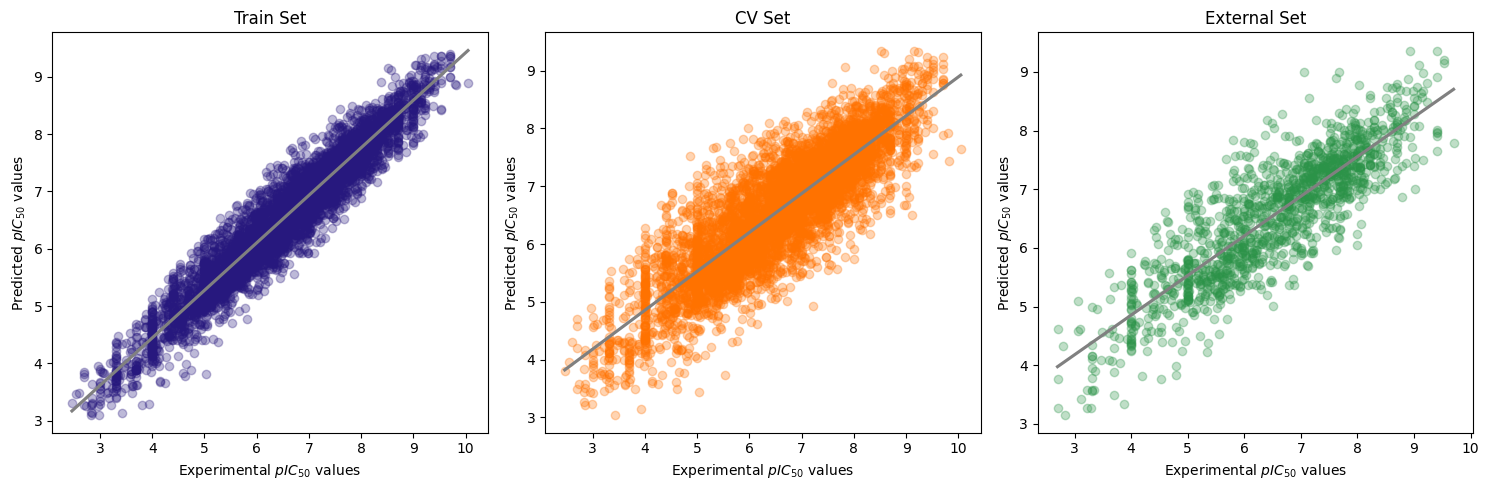

In [ ]:
# Build the model using filtered datasets
all_metrics_results, models, feature_importances_results, y_scrambling_results_external, y_scrambling_results_internal, rf = AD6_build_model(
    X_internal_filtered_6,
    Y_internal_filtered_6,
    X_external_filtered_6,
    Y_external_filtered_6
)

# CSV for all metrics
pd.DataFrame(all_metrics_results).to_csv('/content/gdrive/Shareddrives/Thesis (PS4)/[01] Colab/[03] MV/KRC_AD6_model_results_metrics.csv', index=False)

# CSV for feature importances
pd.DataFrame(feature_importances_results['importances_dict']).to_csv('/content/gdrive/Shareddrives/Thesis (PS4)/[01] Colab/[03] MV/KRC_AD6_model_results_importances.csv', index=False)

print("Built model for a single DataFrame.")

##Applicability domain 6


In [ ]:
# Fit and predict using filtered datasets
rf_params = {
    'max_depth': 60,
    'max_features': 'sqrt',
    'min_samples_split': 4,
    'n_estimators': 940,
    'random_state': 42,
    'n_jobs': -1,
    'verbose': 1
}


rf_internal_AD6 = RandomForestRegressor(**rf_params)
rf_internal_AD6.fit(X_internal_filtered_6, Y_internal_filtered_6)

Y_internal_pred_filtered_6 = rf_internal_AD6.predict(X_internal_filtered_6)
Y_external_pred_filtered_6 = rf_internal_AD6.predict(X_external_filtered_6)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 196 tasks      | elapsed:    1.5s
[Parallel(n_jobs=-1)]: Done 446 tasks      | elapsed:    3.7s
[Parallel(n_jobs=-1)]: Done 796 tasks      | elapsed:    7.8s
[Parallel(n_jobs=-1)]: Done 940 out of 940 | elapsed:    8.9s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done 196 tasks      | elapsed:    0.2s
[Parallel(n_jobs=2)]: Done 446 tasks      | elapsed:    0.4s
[Parallel(n_jobs=2)]: Done 796 tasks      | elapsed:    0.8s
[Parallel(n_jobs=2)]: Done 940 out of 940 | elapsed:    0.9s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done 196 tasks      | elapsed:    0.1s
[Par

In [ ]:
# Calculate Mean Squared Error for internal and external datasets
mse_internal_filtered_6 = mean_squared_error(Y_internal_filtered_6, Y_internal_pred_filtered_6)
mse_external_filtered_6 = mean_squared_error(Y_external_filtered_6, Y_external_pred_filtered_6)

In [ ]:
# Calculate Standardized Residuals
std_residuals_internal_filtered_6 = (Y_internal_filtered_6 - Y_internal_pred_filtered_6) / np.sqrt(mse_internal_filtered_6)
std_residuals_external_filtered_6 = (Y_external_filtered_6 - Y_external_pred_filtered_6) / np.sqrt(mse_external_filtered_6)

std_residual_threshold = 3

In [ ]:
# Calculate Leverage (H) values using pseudo-inverse
hat_matrix_internal_filtered_6 = np.dot(X_internal_filtered_6, np.dot(np.linalg.pinv(np.dot(X_internal_filtered_6.T, X_internal_filtered_6)), X_internal_filtered_6.T))
hat_matrix_external_filtered_6 = np.dot(X_external_filtered_6, np.dot(np.linalg.pinv(np.dot(X_internal_filtered_6.T, X_internal_filtered_6)), X_external_filtered_6.T))

leverage_internal_filtered_6 = np.diag(hat_matrix_internal_filtered_6)
leverage_external_filtered_6 = np.diag(hat_matrix_external_filtered_6)


In [ ]:
# Leverage threshold calculation
k = X_internal_filtered_6.shape[1] - 1
n = X_internal_filtered_6.shape[0]
leverage_threshold_filtered_6 = 3 * (k + 1) / n
leverage_threshold_filtered_6

0.046061049168342166

0.04591836734693878


In [ ]:
# Identify outliers based on leverage and standardized residuals
outliers_leverage_internal_filtered_6 = leverage_internal_filtered_6 > leverage_threshold_filtered_6
outliers_std_residual_internal_filtered_6 = np.abs(std_residuals_internal_filtered_6) > std_residual_threshold

outliers_leverage_external_filtered_6 = leverage_external_filtered_6 > leverage_threshold_filtered_6
outliers_std_residual_external_filtered_6 = np.abs(std_residuals_external_filtered_6) > std_residual_threshold

# Combine the conditions to identify outliers
outliers_internal_filtered_6 = outliers_leverage_internal_filtered_6 | outliers_std_residual_internal_filtered_6
outliers_external_filtered_6 = outliers_leverage_external_filtered_6 | outliers_std_residual_external_filtered_6

# Compute the number and percentage of outliers
num_outliers_internal_filtered_6 = np.sum(outliers_internal_filtered_6)
num_outliers_external_filtered_6 = np.sum(outliers_external_filtered_6)

percentage_outliers_internal_filtered_6 = (num_outliers_internal_filtered_6 / len(std_residuals_internal_filtered_6)) * 100
percentage_outliers_external_filtered_6 = (num_outliers_external_filtered_6 / len(std_residuals_external_filtered_6)) * 100

# Print the number and percentage of outliers
print(f"Number of Internal Outliers: {num_outliers_internal_filtered_6}, Percentage: {percentage_outliers_internal_filtered_6:.2f}%")
print(f"Number of External Outliers: {num_outliers_external_filtered_6}, Percentage: {percentage_outliers_external_filtered_6:.2f}%")

Number of Internal Outliers: 7, Percentage: 0.13%
Number of External Outliers: 3, Percentage: 0.22%


Number of Internal Outliers: 17, Percentage: 0.31%
Number of External Outliers: 5, Percentage: 0.36%

In [ ]:
# List compounds for outliers
compounds_internal_outliers_filtered_6 = np.where(outliers_internal_filtered_6)[0]
compounds_external_outliers_filtered_6 = np.where(outliers_external_filtered_6)[0]

# Print compounds and counts for internal and external outliers
print("\nCompounds for Internal Outliers:")
print(compounds_internal_outliers_filtered_6)
print("Count of Internal Outliers:", num_outliers_internal_filtered_6)

print("\nCompounds for External Outliers:")
print(compounds_external_outliers_filtered_6)
print("Count of External Outliers:", num_outliers_external_filtered_6)


percentage_outliers_internal_filtered_6 = (num_outliers_internal_filtered_6 / len(std_residuals_internal_filtered_6)) * 100
percentage_outliers_external_filtered_6 = (num_outliers_external_filtered_6 / len(std_residuals_external_filtered_6)) * 100

# Print the number and percentage of outliers
print(f"Percentage of Internal Outliers: {percentage_outliers_internal_filtered_6:.2f}%")
print(f"Percentage of External Outliers: {percentage_outliers_external_filtered_6:.2f}%")


Compounds for Internal Outliers:
[ 488 1382 2054 2335 3329 4353 5213]
Count of Internal Outliers: 7

Compounds for External Outliers:
[ 365  851 1282]
Count of External Outliers: 3
Percentage of Internal Outliers: 0.13%
Percentage of External Outliers: 0.22%


Compounds for Internal Outliers:
[ 488 1382 2054 2335 3329 4353 5213]
Count of Internal Outliers: 7

Compounds for External Outliers:
[ 365  851 1282]
Count of External Outliers: 3
Percentage of Internal Outliers: 0.13%
Percentage of External Outliers: 0.22%

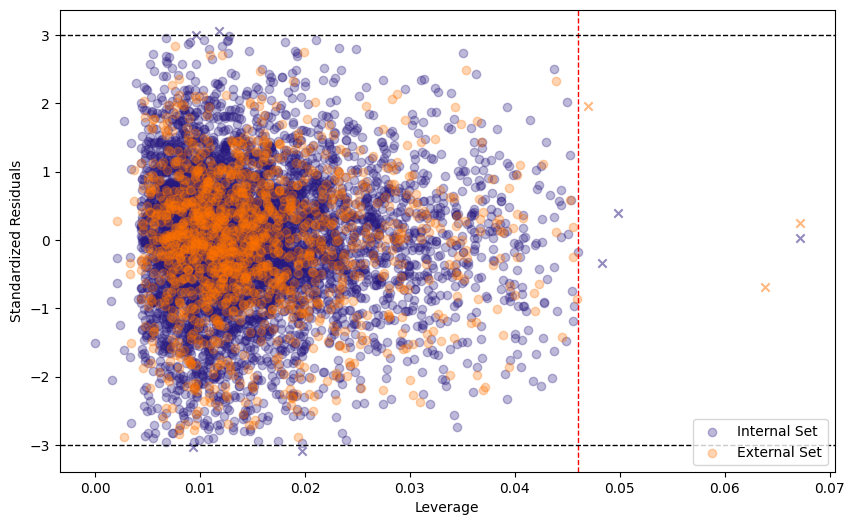

In [ ]:
# Plot
plt.figure(figsize=(10, 6))
plt.scatter(leverage_internal_filtered_6[~outliers_internal_filtered_6], std_residuals_internal_filtered_6[~outliers_internal_filtered_6], alpha=0.3, color='#27187eff', label='Internal Set')
plt.scatter(leverage_internal_filtered_6[outliers_internal_filtered_6], std_residuals_internal_filtered_6[outliers_internal_filtered_6], color='#27187eff', marker="x", alpha=0.5)
plt.scatter(leverage_external_filtered_6[~outliers_external_filtered_6], std_residuals_external_filtered_6[~outliers_external_filtered_6], alpha=0.3, color='#FF7200', label='External Set')
plt.scatter(leverage_external_filtered_6[outliers_external_filtered_6], std_residuals_external_filtered_6[outliers_external_filtered_6], color='#FF7200', marker="x", alpha=0.5)

plt.axvline(x=leverage_threshold_filtered_6, color='red', linestyle='--', linewidth=1)
plt.axhline(y=std_dev, color='black', linestyle='--', linewidth=1)
plt.axhline(y=-std_dev, color='black', linestyle='--', linewidth=1)

plt.xlabel('Leverage')
plt.ylabel('Standardized Residuals')
plt.legend(loc='lower right')

plt.savefig('KRC_AD6_williams_plot.png', dpi=300)
plt.show()


In [ ]:
X_internal_filtered_6.to_csv('X_internal_filtered_6.csv')
Y_internal_filtered_6.to_csv('Y_internal_filtered_6.csv')
X_external_filtered_6.to_csv('X_external_filtered_6.csv')
Y_external_filtered_6.to_csv('Y_external_filtered_6.csv')

In [ ]:
compounds_internal_outliers_filtered_6 = pd.DataFrame(compounds_internal_outliers_filtered_6)
compounds_internal_outliers_filtered_6.to_csv('compounds_internal_outliers_filtered_6.csv', index=False)

#AD MODEL 7

## removing outliers

In [ ]:
Y_internal_filtered_6=pd.read_csv('Y_internal_filtered_6.csv')
Y_external_filtered_6=pd.read_csv('Y_external_filtered_6.csv')
X_internal_filtered_6=pd.read_csv('X_internal_filtered_6.csv')
X_external_filtered_6=pd.read_csv('X_external_filtered_6.csv')
compounds_internal_outliers_filtered_6=pd.read_csv('compounds_internal_outliers_filtered_6.csv')
compounds_external_outliers_filtered_6=pd.read_csv('compounds_external_outliers_filtered_6.csv')

FileNotFoundError: [Errno 2] No such file or directory: 'compounds_internal_outliers_filtered_5.csv'

In [ ]:
# Create a boolean mask for internal and external outliers
mask_internal_outliers_7 = np.isin(np.arange(len(X_internal_filtered_6)), compounds_internal_outliers_filtered_6)
mask_external_outliers_7 = np.isin(np.arange(len(X_external_filtered_6)), compounds_external_outliers_filtered_6)

# Remove internal outliers from training set
X_internal_filtered_7 = X_internal_filtered_6[~mask_internal_outliers_7]
Y_internal_filtered_7 = Y_internal_filtered_6[~mask_internal_outliers_7]

# Remove external outliers from test set
X_external_filtered_7 = X_external_filtered_6[~mask_external_outliers_7]
Y_external_filtered_7 = Y_external_filtered_6[~mask_external_outliers_7]


##AD Defining Functions


In [ ]:
def AD7_Y_scrambling(X_internal, X_external, Y_internal, Y_external, df_name):
    predictionOnExternal_scrambledtrain = []
    predictionOnInternal_scrambledtrain = []

    for randomseedcounter in range(1, 11):  # 10 iterations
        y_train_scrambled = deepcopy(Y_internal.values)
        X_train_scrambled = deepcopy(X_internal.values)

        np.random.shuffle(y_train_scrambled)
        np.random.shuffle(X_train_scrambled)

        RF_scrambled = RandomForestRegressor(max_depth=60,
                                             max_features='sqrt',
                                             min_samples_split=4,
                                             n_estimators=940,
                                             random_state=42,
                                             n_jobs=-1,
                                             verbose=1)  ## TO EDIT BASED FROM BEST HP

        RF_scrambled.fit(X_internal, y_train_scrambled)

        # Prediction on the external set
        y_predict_scrambled = RF_scrambled.predict(X_external)
        r2_test_scrambled = (RF_scrambled.score(X_external, Y_external))**2
        predictionOnExternal_scrambledtrain.append(r2_test_scrambled)

        # Prediction on the internal set
        y_predict_scrambled_predictTrain = RF_scrambled.predict(X_internal)
        r2_train_scrambled = (RF_scrambled.score(X_internal, Y_internal))**2
        predictionOnInternal_scrambledtrain.append(r2_train_scrambled)

    result = pd.DataFrame({
        'R2_scrambled': predictionOnInternal_scrambledtrain,
        'Q2_scrambled': predictionOnExternal_scrambledtrain
    })

    result.to_csv(f'AD7_Y_scrambling_results_{df_name}.csv', index=False)

    return predictionOnExternal_scrambledtrain, predictionOnInternal_scrambledtrain

In [ ]:
def AD7_plot_model(df_name, X_internal, X_external, Y_internal, Y_external, rf, hx):
    # Prepare plot
    fig_size = plt.rcParams["figure.figsize"]
    fig_size[0] = 15
    fig_size[1] = 5

    # Train Set
    plt.subplot(1, 3, 1)
    m = rf.fit(X_internal, Y_internal)
    x_train = np.array(Y_internal)
    y_train = m.predict(X_internal).flatten()
    sns.regplot(x=x_train, y=y_train, scatter_kws={'color': '#27187eff', 'alpha': 0.3}, line_kws={'color': 'gray'}, ci=None)
    plt.xlabel("Experimental $pIC_{50}$ values", fontsize=10)
    plt.ylabel("Predicted $pIC_{50}$ values", fontsize=10)
    plt.title("Train Set")

    # CV Set
    plt.subplot(1, 3, 2)
    cv = cross_val_predict(rf, X_internal, Y_internal, cv=10, n_jobs=-1)
    x_test = np.array(Y_internal)
    y_test = cv
    sns.regplot(x=x_test, y=y_test, scatter_kws={'color': '#FF7200', 'alpha': 0.3}, line_kws={'color': 'gray'}, ci=None)
    plt.xlabel("Experimental $pIC_{50}$ values", fontsize=10)
    plt.ylabel("Predicted $pIC_{50}$ values", fontsize=10)
    plt.title("CV Set")

    # External Set
    plt.subplot(1, 3, 3)
    x_test = np.array(Y_external)
    y_test = m.predict(X_external).flatten()
    sns.regplot(x=x_test, y=y_test, scatter_kws={'color': '#2b9348', 'alpha': 0.3}, line_kws={'color': 'gray'}, ci=None)
    plt.xlabel("Experimental $pIC_{50}$ values", fontsize=10)
    plt.ylabel("Predicted $pIC_{50}$ values", fontsize=10)
    plt.title("External Set")

    plt.tight_layout()
    plt.savefig(f'AD5_{df_name}_compare.png', dpi=300)

In [ ]:
def AD7_build_model(X_internal, Y_internal, X_external, Y_external, config=None):
    if config is None:
        config = {
            'hx': X_internal.columns.tolist(),
            'df_name': 'KlekotaRothCount',
            'rf_params': {
                'max_depth': 60,
                'max_features': 'sqrt',
                'min_samples_split': 4,
                'n_estimators': 940,
                'random_state': 42,
                'n_jobs': -1,
                'verbose': 1
            }
        }

    models = []
    all_metrics_results = {
        'MAE_train': [],
        'R2_train': [],
        'RMSE_train': [],
        'MAE_CV': [],
        'Q2_CV': [],
        'RMSE_CV': [],
        'MAE_External': [],
        'Q2_External': [],
        'RMSE_External': []
    }

    # Extracting parameters from the config dictionary
    hx = config['hx']
    df_name = config['df_name']
    rf_params = config['rf_params']

    feature_importances_results = {
        'importances_dict': defaultdict(list)
    }

    y_scrambling_results_external = []
    y_scrambling_results_internal = []

    # Internal set
    rf = RandomForestRegressor(**rf_params)
    rf.fit(X_internal, Y_internal)
    prediction_internal = rf.predict(X_internal)

    # Cross-validation
    cv = cross_val_predict(rf, X_internal, Y_internal, cv=10, n_jobs=-1)

    # External set
    prediction_external = rf.predict(X_external)

    # Save the trained model using joblib
    model_filename = f'AD7_trained_model_{df_name}.joblib'
    joblib.dump(rf, model_filename)

    # Append the model to the list
    models.append(model_filename)

    # Store results for the single split
    all_metrics_results['MAE_train'].append(mean_absolute_error(Y_internal, prediction_internal))
    all_metrics_results['R2_train'].append(r2_score(Y_internal, prediction_internal))
    all_metrics_results['RMSE_train'].append(np.sqrt(mean_squared_error(Y_internal, prediction_internal)))
    all_metrics_results['MAE_CV'].append(mean_absolute_error(Y_internal, cv))
    all_metrics_results['Q2_CV'].append(r2_score(Y_internal, cv))
    all_metrics_results['RMSE_CV'].append(np.sqrt(mean_squared_error(Y_internal, cv)))
    all_metrics_results['MAE_External'].append(mean_absolute_error(Y_external, prediction_external))
    all_metrics_results['Q2_External'].append(r2_score(Y_external, prediction_external))
    all_metrics_results['RMSE_External'].append(np.sqrt(mean_squared_error(Y_external, prediction_external)))

    # Feature Importance
    feature_importance = rf.feature_importances_
    importances = list(zip(hx, feature_importance))
    importances = sorted(importances, key=lambda x: x[1], reverse=True)

    # Feature importance Visualization
    fig_size = plt.rcParams["figure.figsize"]
    fig_size[0] = 5
    fig_size[1] = 10

    barlist = plt.barh(range(20), [x[1] for x in importances[:20]],
                      color="#27187eff", xerr=[x[1] for x in importances[:20]],
                      align="center", error_kw=dict(ecolor='gray', lw=2, capsize=5, capthick=2))

    plt.yticks(range(20), [x[0] for x in importances[:20]])
    plt.ylim([-1, 20])

    plt.xlabel(r"$\bf{Gini}$" + " " + r"$\bf{index}$", fontsize=12)
    ax = plt.gca()
    ax.invert_yaxis()
    plt.tight_layout(pad=2.0, w_pad=0.7, h_pad=2.0)

    # Save the feature importance plot
    plt.savefig(f'AD7_{df_name}_Feature_importances.png', dpi=300)
    plt.close()

    # Store feature importances
    for i, fx in enumerate(hx):
        feature_importances_results['importances_dict'][fx].append(feature_importance[i])

    # Y Scrambling
    y_scrambling_results_internal_split, y_scrambling_results_external_split = AD7_Y_scrambling(X_internal, X_external, Y_internal, Y_external, df_name)

    y_scrambling_results_external.append(y_scrambling_results_external_split)
    y_scrambling_results_internal.append(y_scrambling_results_internal_split)

    # Plotting
    AD7_plot_model(df_name, X_internal, X_external, Y_internal, Y_external, rf, hx)

    return (
        all_metrics_results,
        models,
        feature_importances_results,
        y_scrambling_results_external,
        y_scrambling_results_internal,
        rf)


##Running all the defined functions

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 196 tasks      | elapsed:    1.5s
[Parallel(n_jobs=-1)]: Done 446 tasks      | elapsed:    3.3s
[Parallel(n_jobs=-1)]: Done 796 tasks      | elapsed:    5.9s
[Parallel(n_jobs=-1)]: Done 940 out of 940 | elapsed:    7.0s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.1s
[Parallel(n_jobs=2)]: Done 196 tasks      | elapsed:    0.2s
[Parallel(n_jobs=2)]: Done 446 tasks      | elapsed:    0.5s
[Parallel(n_jobs=2)]: Done 796 tasks      | elapsed:    0.9s
[Parallel(n_jobs=2)]: Done 940 out of 940 | elapsed:    1.2s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done 196 tasks      | elapsed:    0.1s
[Par

Built model for a single DataFrame.


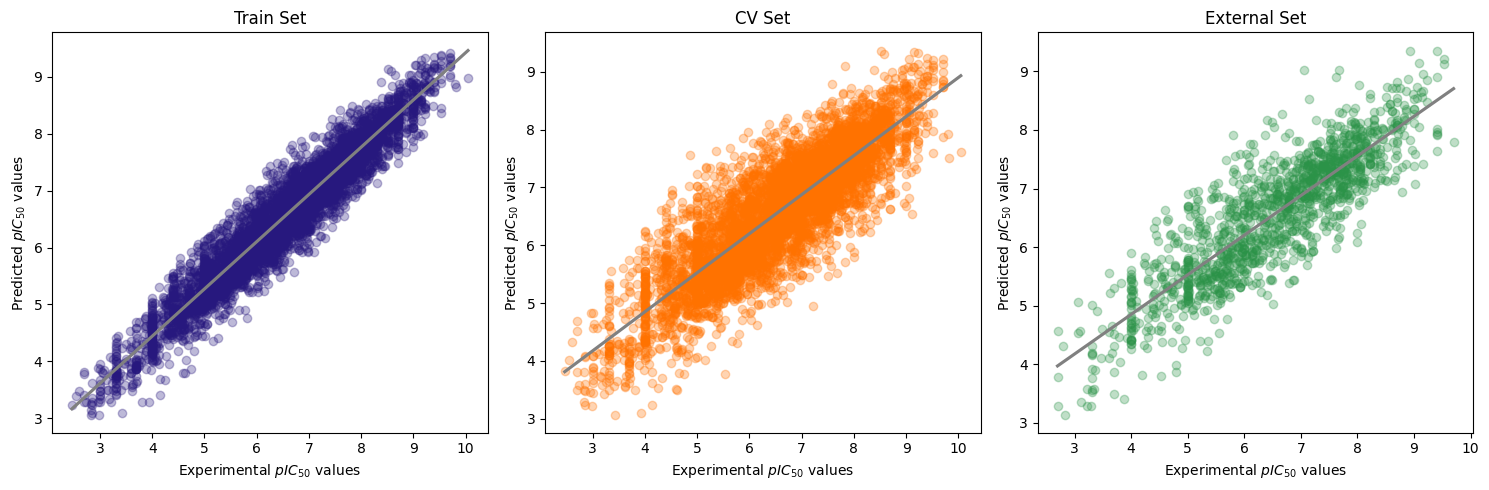

In [ ]:
# Build the model using filtered datasets
all_metrics_results, models, feature_importances_results, y_scrambling_results_external, y_scrambling_results_internal, rf = AD7_build_model(
    X_internal_filtered_7,
    Y_internal_filtered_7,
    X_external_filtered_7,
    Y_external_filtered_7
)

# CSV for all metrics
pd.DataFrame(all_metrics_results).to_csv('/content/gdrive/Shareddrives/Thesis (PS4)/[01] Colab/[03] MV/KRC_AD7_model_results_metrics.csv', index=False)

# CSV for feature importances
pd.DataFrame(feature_importances_results['importances_dict']).to_csv('/content/gdrive/Shareddrives/Thesis (PS4)/[01] Colab/[03] MV/KRC_AD7_model_results_importances.csv', index=False)

print("Built model for a single DataFrame.")

##Applicability domain 7


In [ ]:
# Fit and predict using filtered datasets
rf_params = {
    'max_depth': 60,
    'max_features': 'sqrt',
    'min_samples_split': 4,
    'n_estimators': 940,
    'random_state': 42,
    'n_jobs': -1,
    'verbose': 1
}


rf_internal_AD7 = RandomForestRegressor(**rf_params)
rf_internal_AD7.fit(X_internal_filtered_7, Y_internal_filtered_7)

Y_internal_pred_filtered_7 = rf_internal_AD5.predict(X_internal_filtered_7)
Y_external_pred_filtered_7 = rf_internal_AD5.predict(X_external_filtered_7)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 196 tasks      | elapsed:    1.5s
[Parallel(n_jobs=-1)]: Done 446 tasks      | elapsed:    4.1s
[Parallel(n_jobs=-1)]: Done 796 tasks      | elapsed:    7.7s
[Parallel(n_jobs=-1)]: Done 940 out of 940 | elapsed:    8.7s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done 196 tasks      | elapsed:    0.2s
[Parallel(n_jobs=2)]: Done 446 tasks      | elapsed:    0.4s
[Parallel(n_jobs=2)]: Done 796 tasks      | elapsed:    0.8s
[Parallel(n_jobs=2)]: Done 940 out of 940 | elapsed:    0.9s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done 196 tasks      | elapsed:    0.1s
[Par

In [ ]:
# Calculate Mean Squared Error for internal and external datasets
mse_internal_filtered_7 = mean_squared_error(Y_internal_filtered_7, Y_internal_pred_filtered_7)
mse_external_filtered_7 = mean_squared_error(Y_external_filtered_7, Y_external_pred_filtered_7)

In [ ]:
# Calculate Standardized Residuals
std_residuals_internal_filtered_7 = (Y_internal_filtered_7 - Y_internal_pred_filtered_7) / np.sqrt(mse_internal_filtered_7)
std_residuals_external_filtered_7 = (Y_external_filtered_7 - Y_external_pred_filtered_7) / np.sqrt(mse_external_filtered_7)

std_residual_threshold = 3

In [ ]:
# Calculate Leverage (H) values using pseudo-inverse
hat_matrix_internal_filtered_7 = np.dot(X_internal_filtered_7, np.dot(np.linalg.pinv(np.dot(X_internal_filtered_7.T, X_internal_filtered_7)), X_internal_filtered_7.T))
hat_matrix_external_filtered_7 = np.dot(X_external_filtered_7, np.dot(np.linalg.pinv(np.dot(X_internal_filtered_7.T, X_internal_filtered_7)), X_external_filtered_7.T))

leverage_internal_filtered_7 = np.diag(hat_matrix_internal_filtered_7)
leverage_external_filtered_7 = np.diag(hat_matrix_external_filtered_7)


In [ ]:
# Leverage threshold calculation
k = X_internal_filtered_7.shape[1] - 1
n = X_internal_filtered_7.shape[0]
leverage_threshold_filtered_7 = 3 * (k + 1) / n
leverage_threshold_filtered_7

0.046120058565153735

0.046120058565153735


In [ ]:
# Identify outliers based on leverage and standardized residuals
outliers_leverage_internal_filtered_7 = leverage_internal_filtered_7 > leverage_threshold_filtered_7
outliers_std_residual_internal_filtered_7 = np.abs(std_residuals_internal_filtered_7) > std_residual_threshold

outliers_leverage_external_filtered_7 = leverage_external_filtered_7 > leverage_threshold_filtered_7
outliers_std_residual_external_filtered_7 = np.abs(std_residuals_external_filtered_7) > std_residual_threshold

# Combine the conditions to identify outliers
outliers_internal_filtered_7 = outliers_leverage_internal_filtered_7 | outliers_std_residual_internal_filtered_7
outliers_external_filtered_7 = outliers_leverage_external_filtered_7 | outliers_std_residual_external_filtered_7

# Compute the number and percentage of outliers
num_outliers_internal_filtered_7 = np.sum(outliers_internal_filtered_7)
num_outliers_external_filtered_7 = np.sum(outliers_external_filtered_7)

percentage_outliers_internal_filtered_7 = (num_outliers_internal_filtered_7 / len(std_residuals_internal_filtered_7)) * 100
percentage_outliers_external_filtered_7 = (num_outliers_external_filtered_7 / len(std_residuals_external_filtered_7)) * 100

# Print the number and percentage of outliers
print(f"Number of Internal Outliers: {num_outliers_internal_filtered_7}, Percentage: {percentage_outliers_internal_filtered_7:.2f}%")
print(f"Number of External Outliers: {num_outliers_external_filtered_7}, Percentage: {percentage_outliers_external_filtered_7:.2f}%")

Number of Internal Outliers: 3, Percentage: 0.05%
Number of External Outliers: 0, Percentage: 0.00%


Number of Internal Outliers: 3, Percentage: 0.05%
Number of External Outliers: 0, Percentage: 0.00%

In [ ]:
# List compounds for outliers
compounds_internal_outliers_filtered_7 = np.where(outliers_internal_filtered_7)[0]
compounds_external_outliers_filtered_7 = np.where(outliers_external_filtered_7)[0]

# Print compounds and counts for internal and external outliers
print("\nCompounds for Internal Outliers:")
print(compounds_internal_outliers_filtered_7)
print("Count of Internal Outliers:", num_outliers_internal_filtered_7)

print("\nCompounds for External Outliers:")
print(compounds_external_outliers_filtered_7)
print("Count of External Outliers:", num_outliers_external_filtered_7)


percentage_outliers_internal_filtered_7 = (num_outliers_internal_filtered_7 / len(std_residuals_internal_filtered_7)) * 100
percentage_outliers_external_filtered_7 = (num_outliers_external_filtered_7 / len(std_residuals_external_filtered_7)) * 100

# Print the number and percentage of outliers
print(f"Percentage of Internal Outliers: {percentage_outliers_internal_filtered_7:.2f}%")
print(f"Percentage of External Outliers: {percentage_outliers_external_filtered_7:.2f}%")


Compounds for Internal Outliers:
[3338 3668 4223]
Count of Internal Outliers: 3

Compounds for External Outliers:
[]
Count of External Outliers: 0
Percentage of Internal Outliers: 0.05%
Percentage of External Outliers: 0.00%


Compounds for Internal Outliers:
[3338 3668 4223]
Count of Internal Outliers: 3

Compounds for External Outliers:
[]
Count of External Outliers: 0
Percentage of Internal Outliers: 0.05%
Percentage of External Outliers: 0.00%

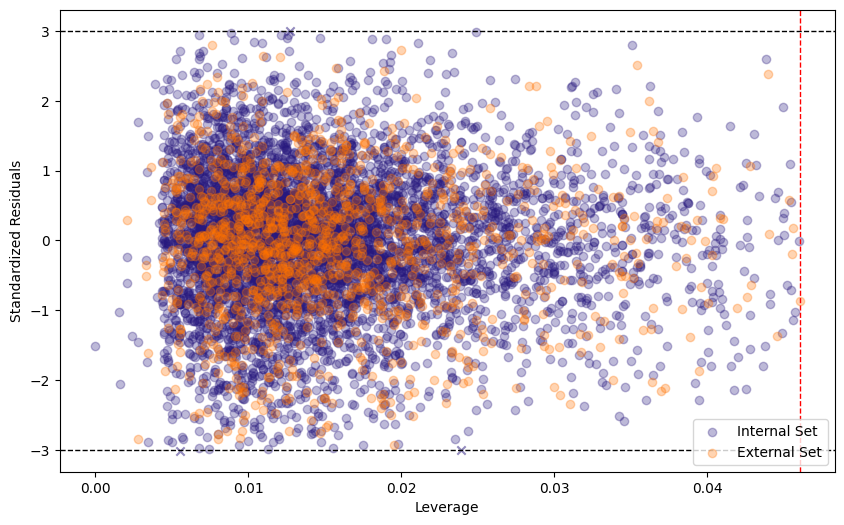

In [ ]:
# Plot
plt.figure(figsize=(10, 6))
plt.scatter(leverage_internal_filtered_7[~outliers_internal_filtered_7], std_residuals_internal_filtered_7[~outliers_internal_filtered_7], alpha=0.3, color='#27187eff', label='Internal Set')
plt.scatter(leverage_internal_filtered_7[outliers_internal_filtered_7], std_residuals_internal_filtered_7[outliers_internal_filtered_7], color='#27187eff', marker="x", alpha=0.5)
plt.scatter(leverage_external_filtered_7[~outliers_external_filtered_7], std_residuals_external_filtered_7[~outliers_external_filtered_7], alpha=0.3, color='#FF7200', label='External Set')
plt.scatter(leverage_external_filtered_7[outliers_external_filtered_7], std_residuals_external_filtered_7[outliers_external_filtered_7], color='#FF7200', marker="x", alpha=0.5)

plt.axvline(x=leverage_threshold_filtered_6, color='red', linestyle='--', linewidth=1)
plt.axhline(y=std_dev, color='black', linestyle='--', linewidth=1)
plt.axhline(y=-std_dev, color='black', linestyle='--', linewidth=1)

plt.xlabel('Leverage')
plt.ylabel('Standardized Residuals')
plt.legend(loc='lower right')

plt.savefig('KRC_AD7_williams_plot.png', dpi=300)
plt.show()


In [ ]:
X_internal_filtered_7.to_csv('X_internal_filtered_7.csv')
Y_internal_filtered_7.to_csv('Y_internal_filtered_7.csv')
X_external_filtered_7.to_csv('X_external_filtered_7.csv')
Y_external_filtered_7.to_csv('Y_external_filtered_7.csv')

In [ ]:
compounds_internal_outliers_filtered_7 = pd.DataFrame(compounds_internal_outliers_filtered_7)
compounds_internal_outliers_filtered_7.to_csv('compounds_internal_outliers_filtered_7.csv', index=False)